In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')

MNET_PATH = '/Users/anamaria/git/molnet/code/'
sys.path.append(MNET_PATH)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
WIN = 'D:/'
MAC = '/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/'

osp = MAC

In [2]:
import GPy


In [5]:
GPy

<module 'GPy' from '/Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/__init__.py'>

In [155]:
data = pd.read_csv(osp+'covid19_data/compound_data.csv', index_col = 0)
sample_description = pd.read_csv(osp+'covid19_data/compound_design.csv', index_col = 0)


data.fillna(0,inplace=True)
data_log = np.log2(data+1)

In [156]:
data_log.index.name = None

In [157]:
data_log_unique = data_log[~data_log.index.duplicated(keep='first')]

In [158]:
output_dir = osp+'/covid19_data/'
sample_description_file = output_dir + 'sample_description.csv'
data_log_file = output_dir + 'data_log.csv'


sample_description.to_csv(sample_description_file, header=True, index=True, sep=',', mode='w')
data_log_unique.to_csv(data_log_file, header=True,index = True,sep=',', mode='w')

In [159]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [160]:
%%R

library(limma)
library(Biobase)

In [161]:
%%R -i data_log_file -i sample_description_file
options(error=recover)

eset = readExpressionSet(data_log_file, sample_description_file, 
                         exprsArgs=list(sep=",", header = TRUE, row.names = "X"),
                         phenoDataArgs=list(sep=","))

edata = exprs(eset)
pheno = pData(eset)

#creating the levels for the Condition and Dataset in pData
levels(pheno$group) = c('healthy','nonCOVID19', 'nonsevere', 'severe')

pData(eset) = pheno



In [162]:
limma_table_file_nonsevere = osp+'/covid19_data/limma_independent_healthy_nonsevere.csv'
limma_table_file_severe = osp+'/covid19_data/limma_independent_healthy_severe.csv'

In [164]:
%%R -i limma_table_file_nonsevere -i limma_table_file_severe

eset.group = factor(as.character(pData(eset)$group))

eset.design = model.matrix(~ 0 + eset.group)
eset.fit = lmFit(eset, eset.design)


#define the contrasts you want to make, estimate the coefficients 
#and std errs for these contrasts, eBayes moderation of std errs.
contr1 = makeContrasts(eset.groupsevere - eset.grouphealthy, levels=colnames(coef(eset.fit)))
eset.fit1 = contrasts.fit(eset.fit, contr1)
eset.fit1 = eBayes(eset.fit1)

contr2 = makeContrasts(eset.groupnonsevere - eset.grouphealthy, levels=colnames(coef(eset.fit)))
eset.fit2 = contrasts.fit(eset.fit, contr2)
eset.fit2 = eBayes(eset.fit2)

#Extract results per metabolite
top.table1 = topTable(eset.fit1, sort.by="p", n=Inf)
top.table2 = topTable(eset.fit2, sort.by="p", n=Inf)

write.csv(top.table1, file = limma_table_file_severe, sep = ",", quote = FALSE)
write.csv(top.table2, file = limma_table_file_nonsevere, sep = ",", quote = FALSE)


In [165]:
def get_limma_table(limma_table_file):
    limma_table = pd.read_csv(limma_table_file, sep=',')
    limma_table.index = limma_table[limma_table.columns[0]]
    del limma_table[(limma_table.columns[0])]
    return limma_table

In [176]:
limma_severe = get_limma_table(limma_table_file_severe)
limma_nonsevere = get_limma_table(limma_table_file_nonsevere)

In [149]:
sys.path.append('..')
import peakinfo
import pickle
with open(osp+'pymz/mzmine/peak_picked_files/peakinfolist.dict', 'rb') as file:
    peakinfolist = pickle.load(file)

In [130]:
import os
with open(os.path.join(osp,'Metabolomics_datasets/metabolites.dict'), 'rb') as file:
    metabolites = pickle.load(file)

In [132]:
def get_metab_name_by_kegg(metabolites_dict, kegg_id):
    for hmdb in metabolites_dict:
        if metabolites_dict[hmdb][5] == kegg_id:
            return metabolites_dict[hmdb][2]

In [170]:
limma_severe.sort_index(inplace=True)
limma_nonsevere.sort_index(inplace=True)

In [181]:
data_log_unique.loc['C00148']

h_jkdz1    29.723644
h_jkdz2    29.739982
h_jkdz3    29.464223
h_jkdz4    30.466089
h_jkdz5    30.004036
             ...    
s_ZX17     29.232357
s_ZX18     28.235407
s_ZX19     28.744549
s_ZX20     29.301792
s_ZX21     28.890709
Name: C00148, Length: 96, dtype: float64

C00099 2.47387762248843
['C00099'] 0.0   beta-Alanine


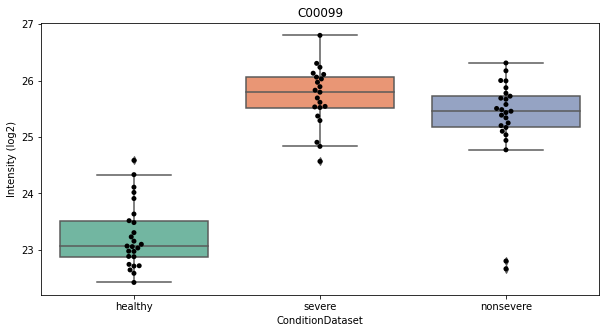

C00099 2.47387762248843
['C00213', 'C00041', 'C00099', 'C00133'] -0.19126331540117997 ['sarcosine; n-methylglycine$l-alanine$beta-alanine$d-alanine']  


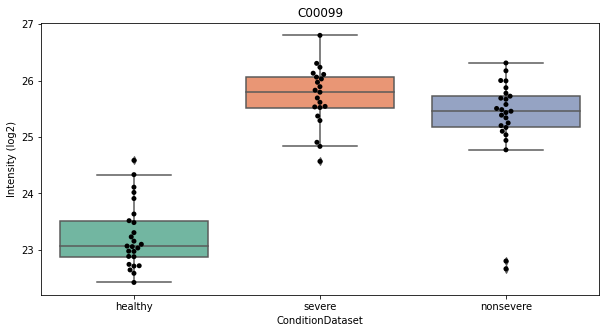

C00099 2.47387762248843
['C00213', 'C00041', 'C00099', 'C00133', 'C00041'] -0.177064931766978 ['sarcosine; n-methylglycine$l-alanine$beta-alanine$d-alanine'] l-alanine 


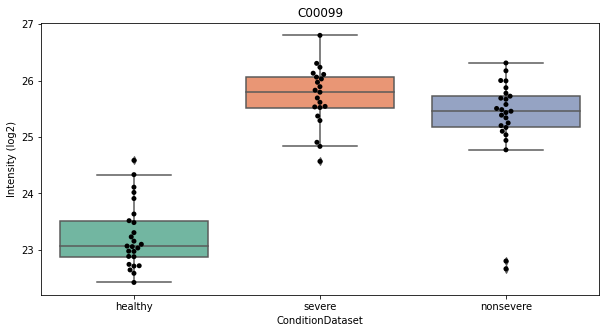

C00148 -0.9391795125412479
['C00148'] 0.0   L-Proline


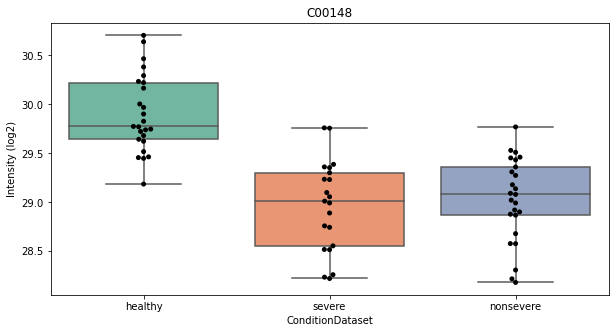

C00148 -0.9391795125412479
['CE1944', 'C00148'] -0.06299012971078 ['4-aminobutanal; 4-aminobutyraldehyde; butyraldehyde, 4-amino-', '1-pyrroline']  L-Proline


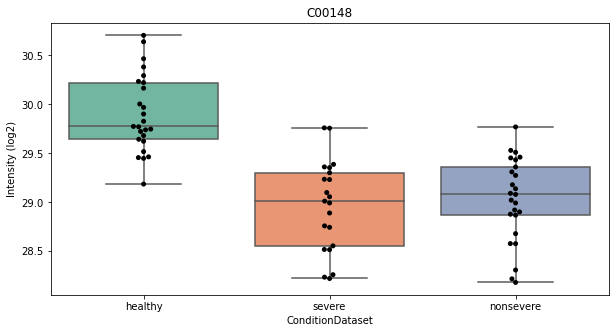

C00148 -0.9391795125412479
['C00122', 'C00148'] -0.0560273730679093  maleic acid L-Proline


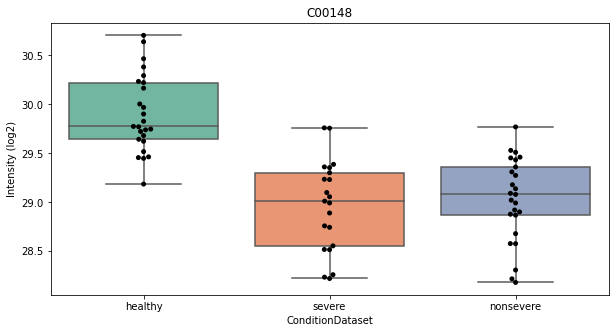

C00148 -0.9391795125412479
['CE4788', 'C00763', 'C00148'] -0.55422303933355 ['acetamidopropanal$d-proline$l-proline']  


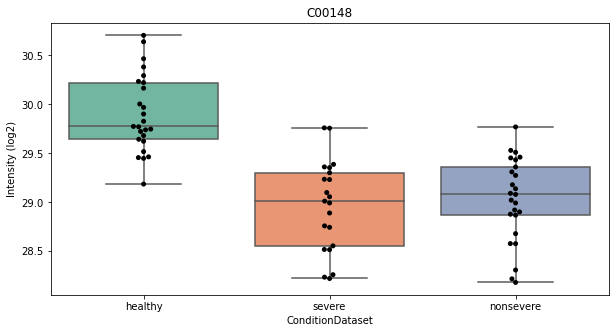

C00148 -0.9391795125412479
['CE4788', 'C00763', 'C00148'] -0.00326709502646594 ['acetamidopropanal$d-proline$l-proline']  


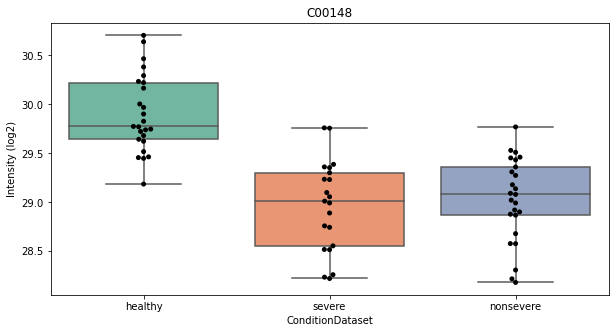

C00327 -0.925279030095854
['C00327'] -0.355305887405596 ['l-citrulline; 2-amino-5-ureidovaleric acid; citrulline']  


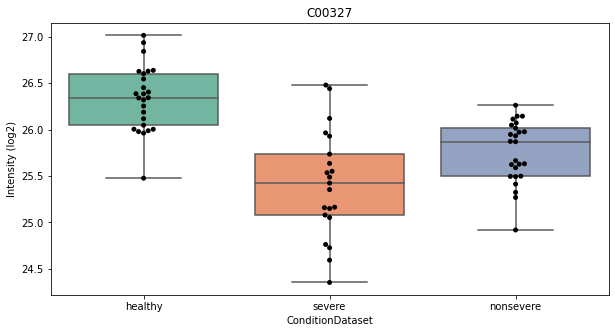

C00327 -0.925279030095854
['C00327'] -0.32020872958735996 ['l-citrulline; 2-amino-5-ureidovaleric acid; citrulline'] l-citrulline 


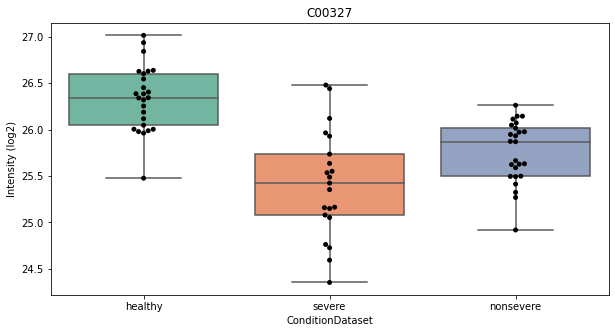

C00327 -0.925279030095854
['C00327'] -0.323701005863317 ['l-citrulline; 2-amino-5-ureidovaleric acid; citrulline']  


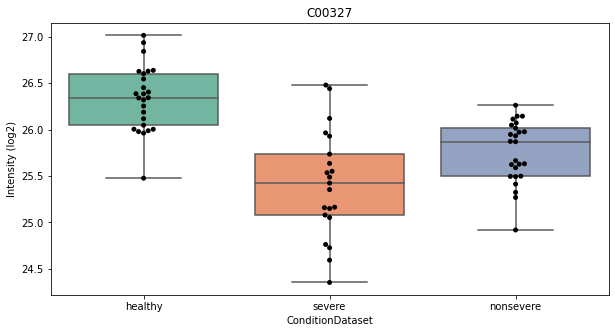

C00327 -0.925279030095854
['C00327'] 0.0562788853542813 ['l-citrulline; 2-amino-5-ureidovaleric acid; citrulline']  


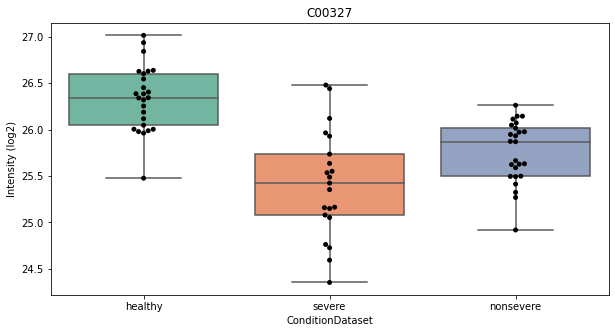

C00047 -0.7510652849943009
['C00906', 'C00064', 'C00047'] -2.63034608332642 ['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid', '5,6-dihydrothymine'] l-glutamine L-Lysine


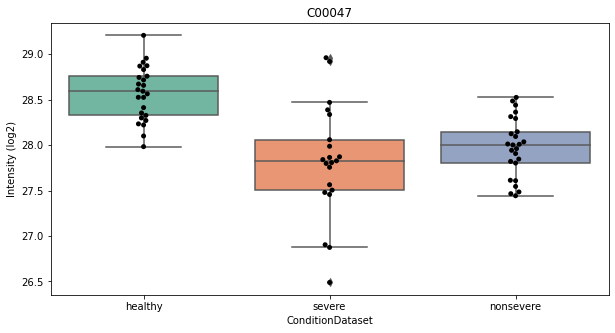

C00047 -0.7510652849943009
['C00047', 'C00408'] -0.160909698672775 ['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid', 'l-lysine'] 5-oxoproline Pipecolic acid


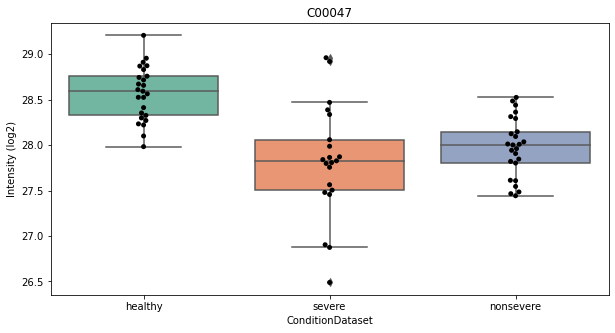

C00047 -0.7510652849943009
['C00047'] 0.3648836210393929 ['l-lysine']  


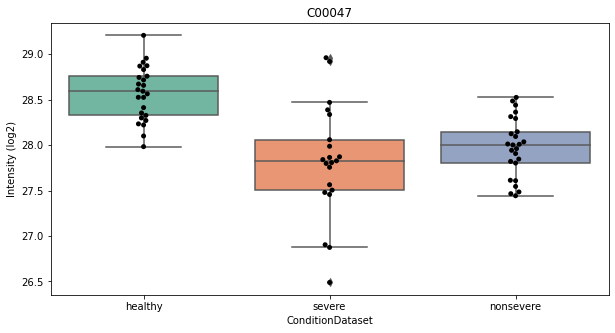

C00407 -0.8641517069083159
['C00123', 'C00407'] 0.176076671475901 ['l-leucine$l-isoleucine']  


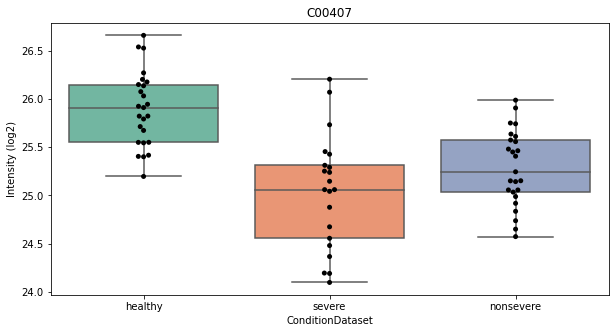

C00407 -0.8641517069083159
['C00123', 'C00407', 'C00123'] 0.171461238144822 ['5-acetamidopentanoate', 'l-leucine$l-isoleucine'] l-leucine 


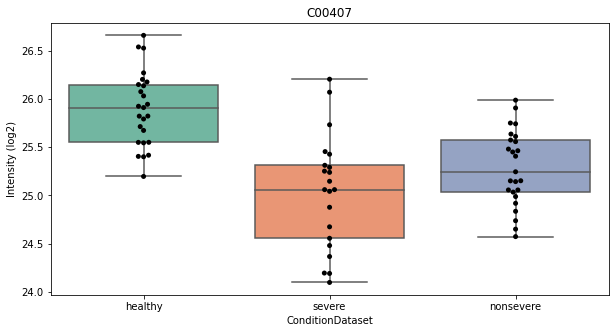

C00407 -0.8641517069083159
['C00123', 'C00407'] 2.2426128000308396 ['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid', 'l-leucine$l-isoleucine']  


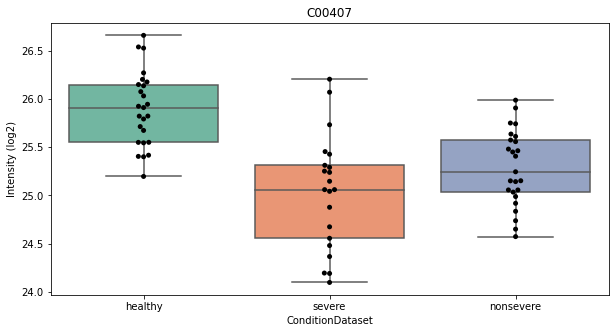

C00407 -0.8641517069083159
['C00123', 'C00407', 'C01026'] 1.00945547849601 ['l-leucine$l-isoleucine']  Dimethylglycine


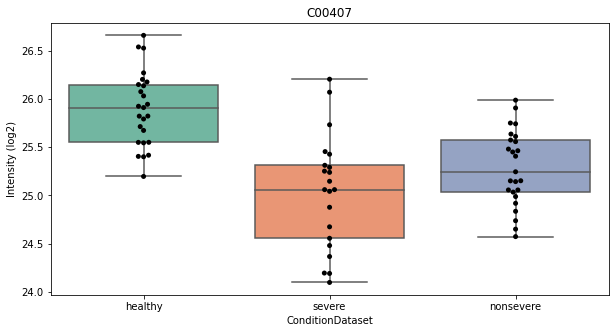

C00407 -0.8641517069083159
['C00123', 'C00407'] -0.0352650335794138 ['5-acetamidopentanoate', 'l-leucine$l-isoleucine']  


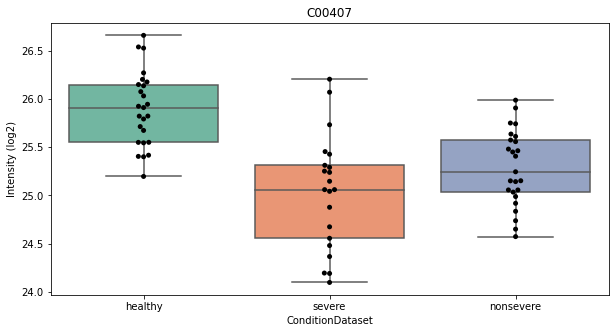

C00077 -0.9004682072283109
['C00077', 'C00515', 'C01602'] 0.584619746833702 ['ornithine$d-ornithine$ornithine; 2,5-diaminovaleric acid; 2,5-diaminopentanoic acid; 2,5-diaminopentanoate']  


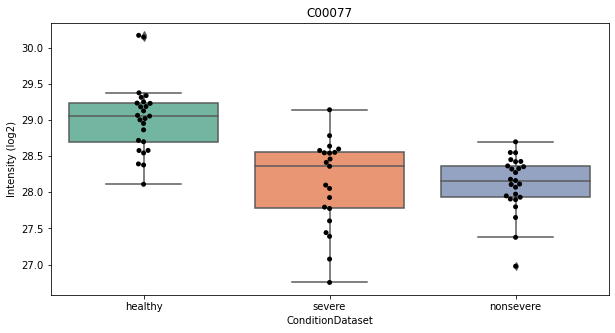

C00152 -0.7034390223558061
['C02642', 'C00152'] 1.75011143914939 ['n-carbamoyl-beta-alanine$l-asparagine']  


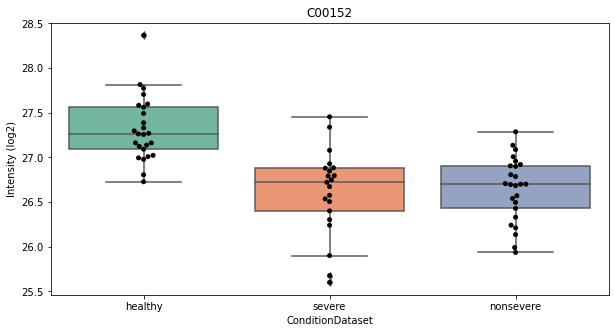

C00152 -0.7034390223558061
['C02642', 'C00152', 'C00300'] -0.563278369095048 ['n-carbamoyl-beta-alanine$l-asparagine'] glycylglycine Creatine


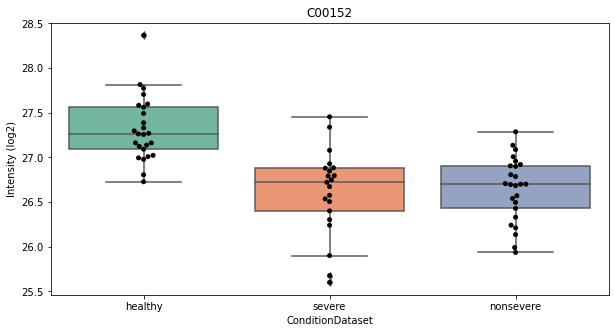

C00188 -0.8099542461282779
['C05519', 'C00188'] -5.730288516100289 ['d-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde', 'l-allo-threonine$l-threonine']  


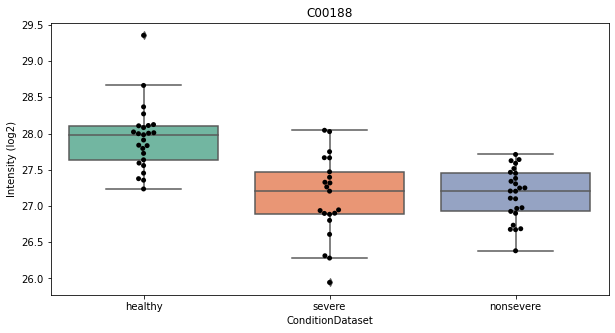

C00188 -0.8099542461282779
['C05519', 'C00188', 'C00408'] -0.462357094192591 ['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate', 'l-allo-threonine$l-threonine']  Pipecolic acid


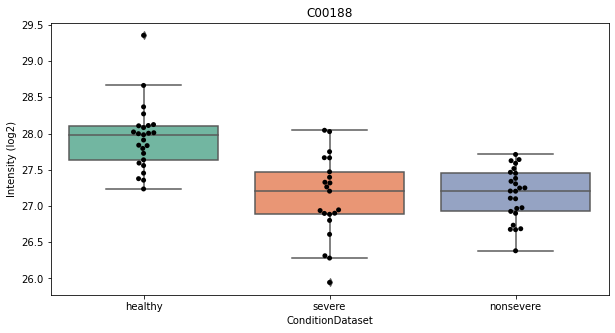

C00188 -0.8099542461282779
['C05519', 'C00188'] 0.535536762546421 ['d-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde', 'l-allo-threonine$l-threonine']  


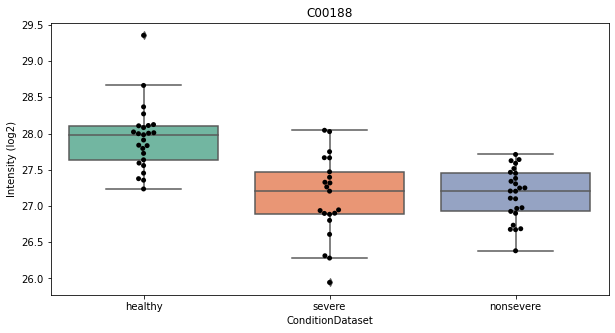

C00188 -0.8099542461282779
['C05519', 'C00188'] 0.0669998636350009 ['l-allo-threonine$l-threonine']  


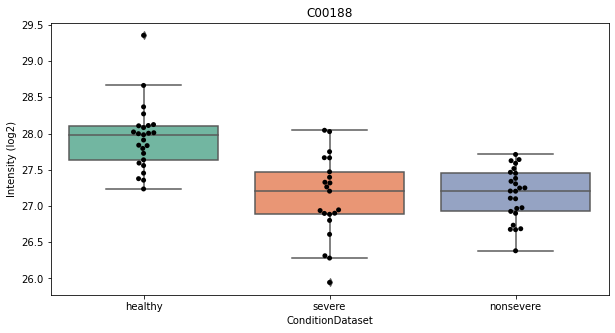

C00188 -0.8099542461282779
['C05519', 'C00188', 'C00263', 'C00188'] 0.0597256686249992 ['d-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde', 'l-allo-threonine$l-threonine'] l-homoserine L-Threonine


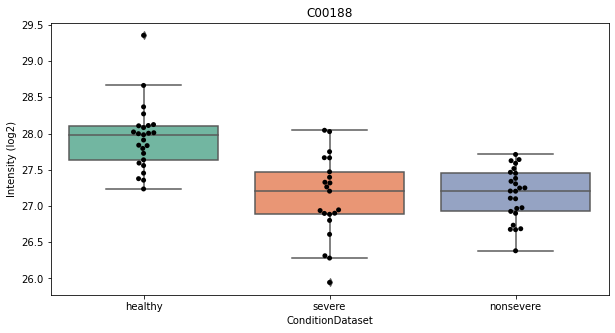

C00188 -0.8099542461282779
['C05519', 'C00188'] -0.34305280130098803 ['l-allo-threonine$l-threonine']  


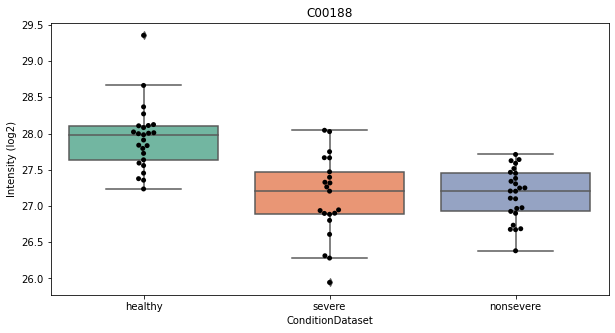

C00188 -0.8099542461282779
['C05519', 'C00188'] -0.312855419792593 ['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate', 'd-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde', 'l-allo-threonine$l-threonine']  


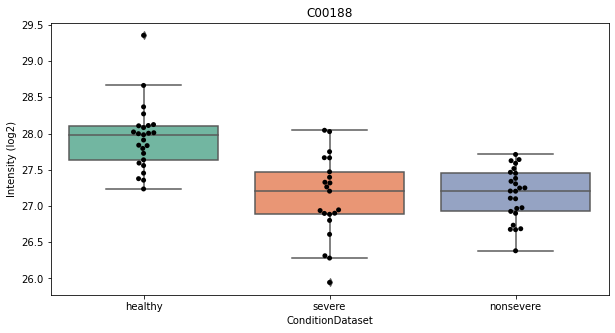

C00135 -0.780707853565868
['C00135'] -4.99007224281755 ['5-guanidino-2-oxopentanoate; 5-guanidino-2-oxo-pentanoate; 2-oxo-5-guanidinopentanoate; 2-oxo-5-guanidino-pentanoate', 'l-histidine']  


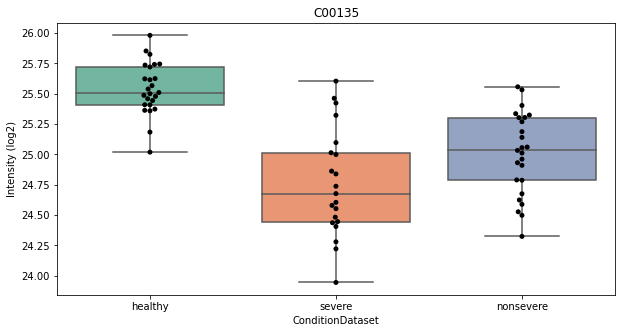

C00135 -0.780707853565868
['C00135'] -0.308798235873276 ['l-histidine']  


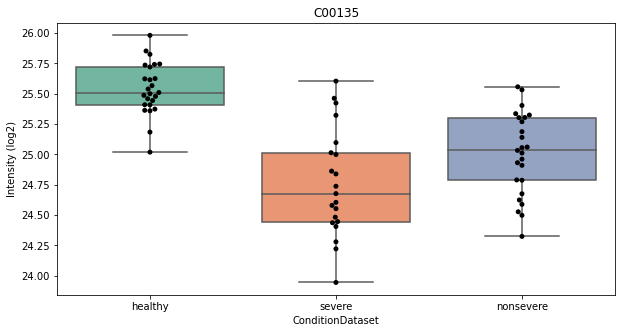

C00135 -0.780707853565868
['C00135', 'C00135'] 1.3576680670986598 ['5-guanidino-2-oxopentanoate; 5-guanidino-2-oxo-pentanoate; 2-oxo-5-guanidinopentanoate; 2-oxo-5-guanidino-pentanoate', 'l-histidine']  L-Histidine


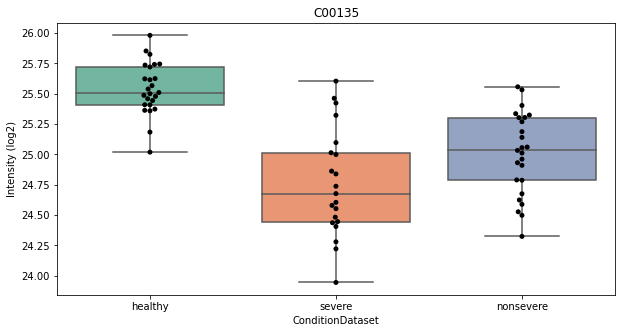

C00581 -8.31032850074227
['C00581', 'gudac'] -0.0393917063831459 ['guanidinoacetate; guanidinoacetic acid; glycocyamine; n-amidinoglycine; guanidoacetic acid$guanidinoacetate']  


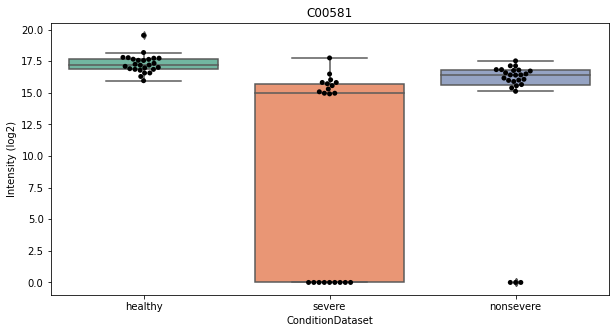

C00245 -0.9046016959644481
['C00245', 'C00245'] -1.04710511580883 ['taurine'] taurine 


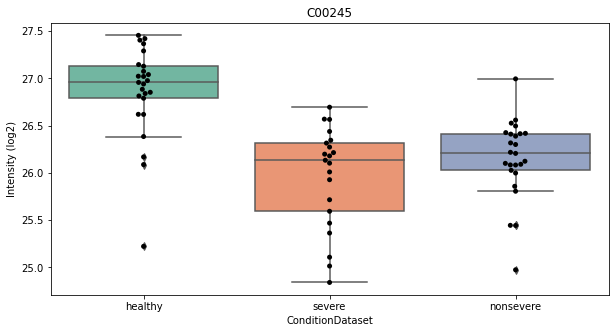

C00123 -0.62345937010878
['C00123'] 0.28491136535046396  l-leucine 


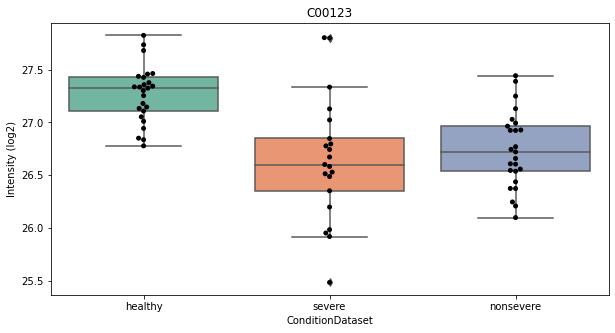

C00123 -0.62345937010878
['C00123', 'C00407'] 0.176076671475901 ['l-leucine$l-isoleucine']  


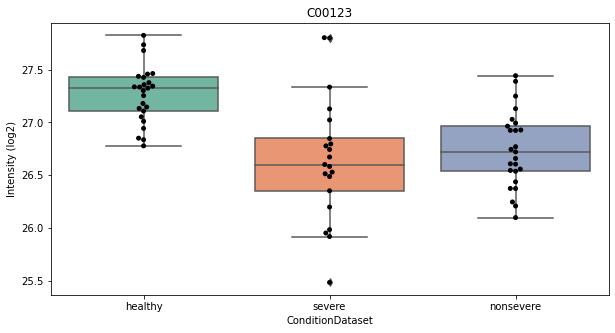

C00123 -0.62345937010878
['C00123', 'C00407', 'C00123'] 0.171461238144822 ['5-acetamidopentanoate', 'l-leucine$l-isoleucine'] l-leucine 


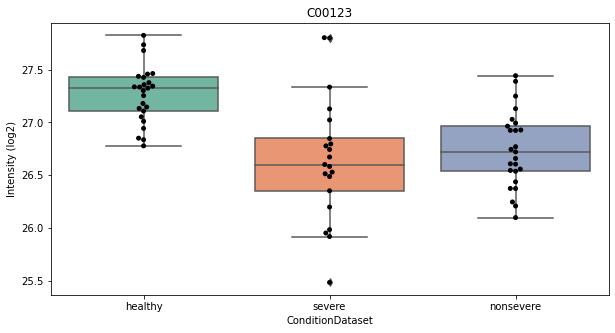

C00123 -0.62345937010878
['C00123', 'C00407'] 2.2426128000308396 ['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid', 'l-leucine$l-isoleucine']  


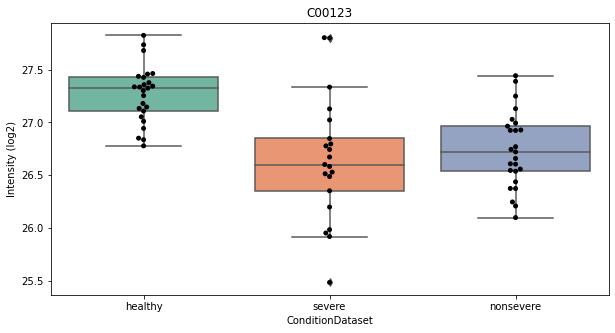

C00123 -0.62345937010878
['C00123', 'C00407', 'C01026'] 1.00945547849601 ['l-leucine$l-isoleucine']  Dimethylglycine


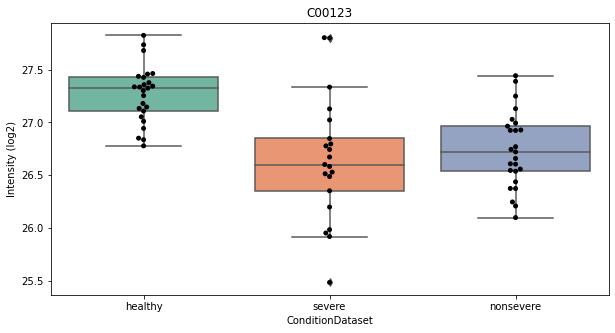

C00123 -0.62345937010878
['C00123', 'C00407'] -0.0352650335794138 ['5-acetamidopentanoate', 'l-leucine$l-isoleucine']  


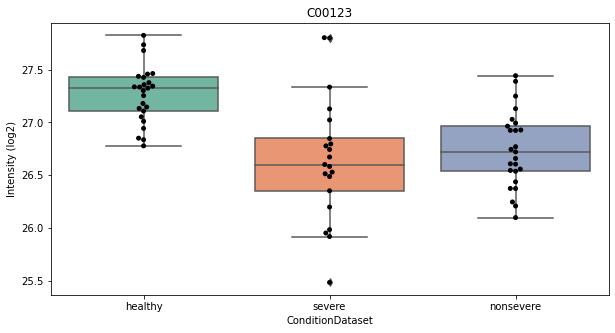

C00123 -0.62345937010878
['C00123'] -1.03106609671615  l-leucine 


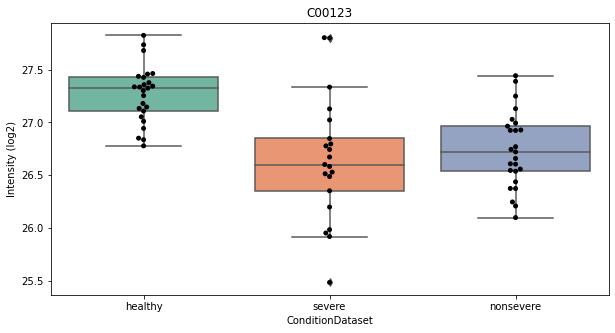

C00037 -0.604983228756804
['C00037', 'C00037'] 0.13749335941611202 ['glycine'] glycine 


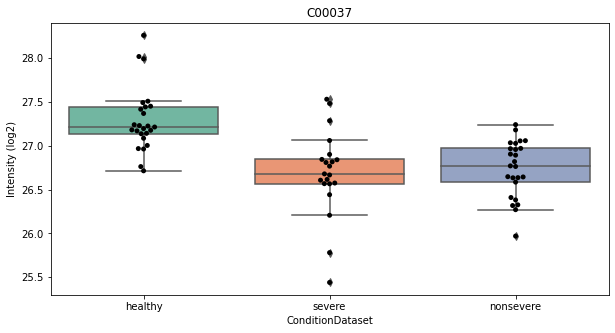

C00041 -0.378895629955249
['C00041'] 0.0  l-alanine 


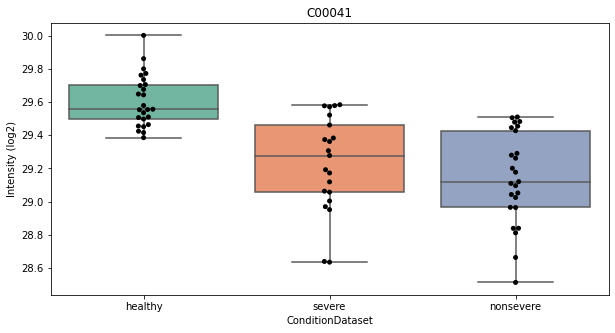

C00041 -0.378895629955249
['C00213', 'C00041', 'C00099', 'C00133'] -0.19126331540117997 ['sarcosine; n-methylglycine$l-alanine$beta-alanine$d-alanine']  


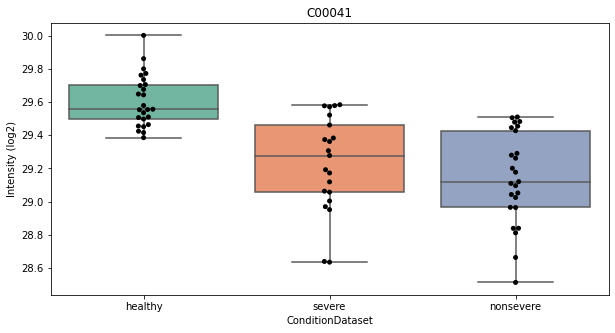

C00041 -0.378895629955249
['C00213', 'C00041', 'C00099', 'C00133', 'C00041'] -0.177064931766978 ['sarcosine; n-methylglycine$l-alanine$beta-alanine$d-alanine'] l-alanine 


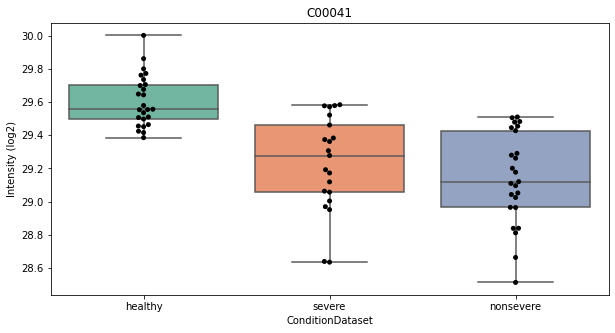

C00114 -0.508998497176368
['C00114', 'C01026'] 0.0  choline Dimethylglycine


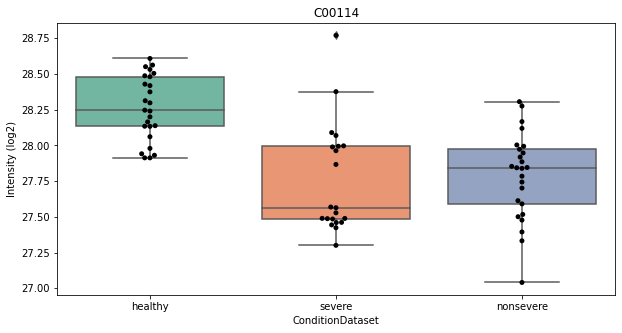

C00213 -0.9885510085587329
['C00213', 'C00041', 'C00099', 'C00133'] -0.19126331540117997 ['sarcosine; n-methylglycine$l-alanine$beta-alanine$d-alanine']  


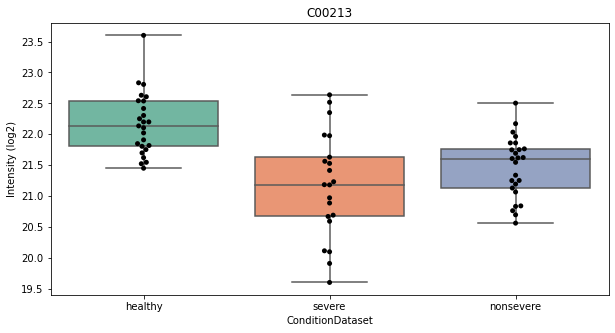

C00213 -0.9885510085587329
['C00213', 'C00041', 'C00099', 'C00133', 'C00041'] -0.177064931766978 ['sarcosine; n-methylglycine$l-alanine$beta-alanine$d-alanine'] l-alanine 


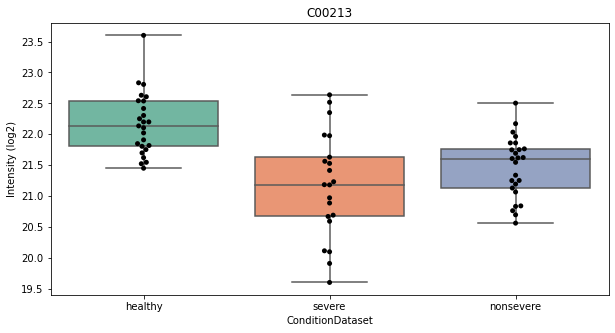

C00328 0.9248002455018349
['C00328', 'C05647', 'C00328', 'C00328'] 0.588843857846385 ['porphobilinogen', 'l-kynurenine$formyl-5-hydroxykynurenamine'] l-kynurenine L-Kynurenine


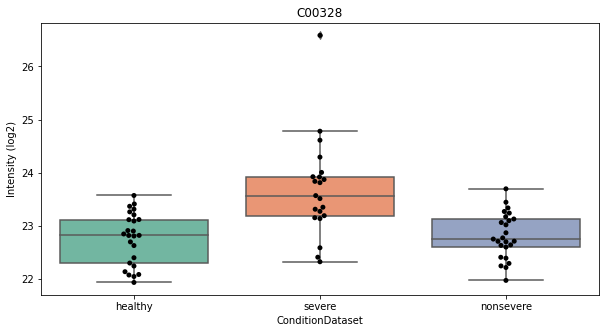

C05938 -9.727082726530869
['C00217', 'C00025', 'C05938', 'C00408'] -0.649141706140043 ['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate$5-oxo-l-proline', 'd-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde'] 5-oxoproline Pipecolic acid


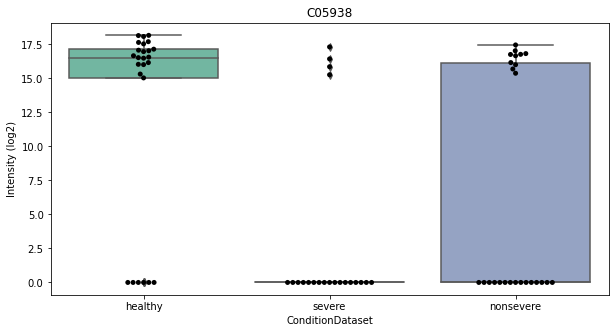

C05938 -9.727082726530869
['C00217', 'C00025', 'C05938'] -1.3978289832822999 ['d-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde']  


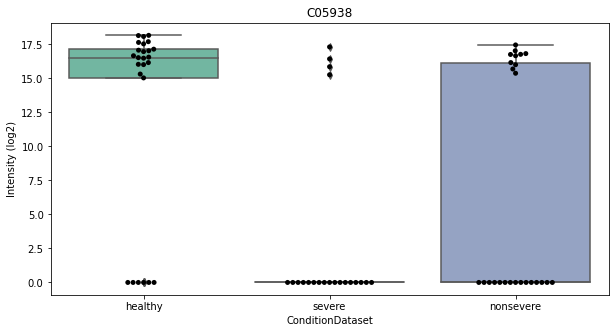

C00300 -1.1955968332104099
['C02642', 'C00152', 'C00300'] -0.563278369095048 ['n-carbamoyl-beta-alanine$l-asparagine'] glycylglycine Creatine


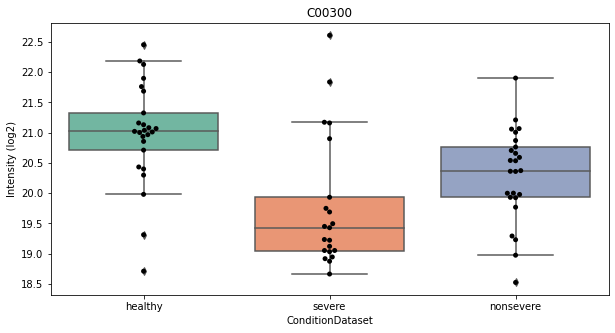

C00300 -1.1955968332104099
['C00300', 'C06804'] 2.62781762239009 ['creatine; alpha-methylguanidino acetic acid; methylglycocyamine']  Acetaminophen


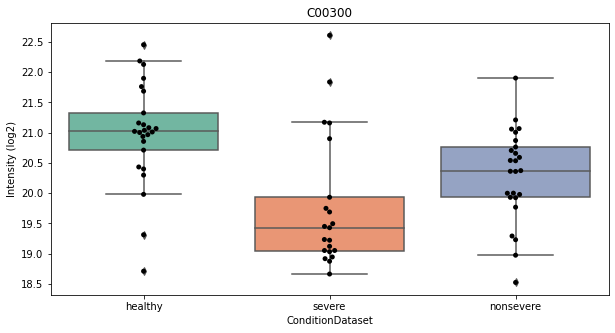

C00300 -1.1955968332104099
['C00300'] -0.172445474873548 ['creatine; alpha-methylguanidino acetic acid; methylglycocyamine'] glycylglycine 


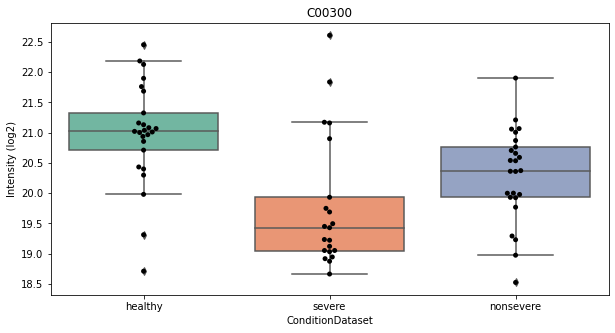

C00300 -1.1955968332104099
['C03341', 'C00300'] 0.12047423714031401 ['l-glutamate 5-semialdehyde; l-glutamate gamma-semialdehyde$trans-4-hydroxy-l-proline$5-aminolevulinate; 5-amino-4-oxopentanoate; 5-amino-4-oxovaleric acid$cis-4-hydroxy-d-proline$5-amino-2-oxopentanoic acid; 5-amino-2-oxopentanoate; 2-oxo-5-amino-pentanoate; 2-oxo-5-aminopentanoate; alpha-keto-delta-aminopentanoate; 2-oxo-5-aminovalerate', '2-amino-4-oxopentanoic acid; 2-amino-4-oxopentanoate'] 5-aminolevulinate Creatine


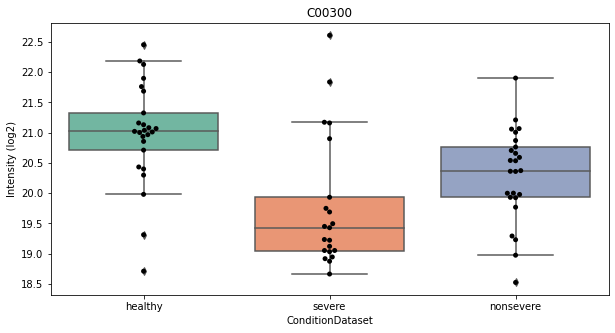

C00065 -0.43361693651011296
['C00065', 'C00065'] 0.0  l-serine L-Serine


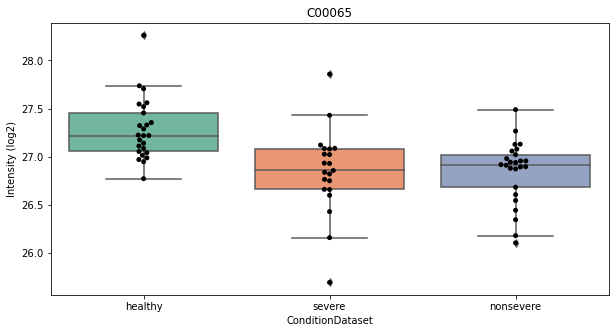

C00065 -0.43361693651011296
['C00065'] 0.0  l-serine 


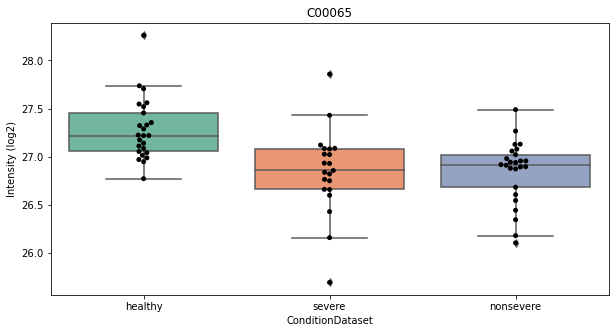

C00065 -0.43361693651011296
['C00065', 'C00740', 'C00065'] 0.322779801179106 ['l-serine$d-serine'] l-serine 


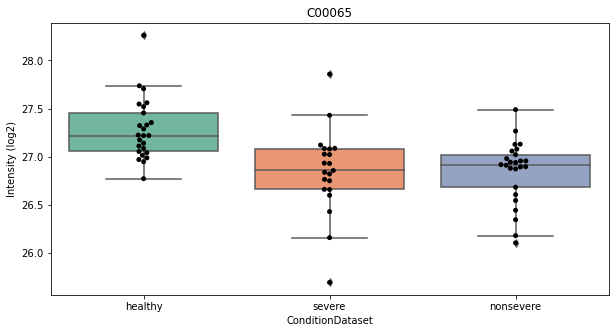

C02642 0.7983221147279631
['C02642', 'C00152'] 1.75011143914939 ['n-carbamoyl-beta-alanine$l-asparagine']  


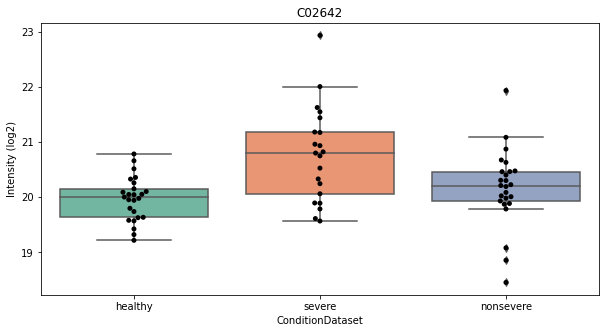

C02642 0.7983221147279631
['C02642', 'C00152', 'C00300'] -0.563278369095048 ['n-carbamoyl-beta-alanine$l-asparagine'] glycylglycine Creatine


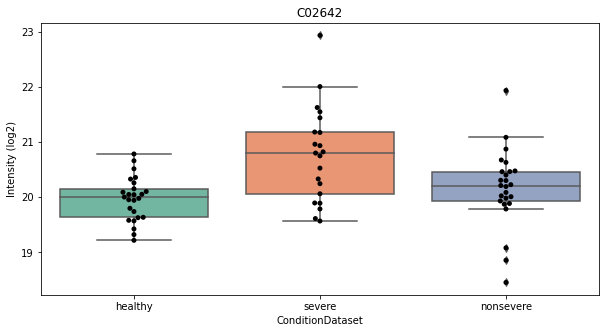

C00064 -0.39963493371366704
['C00906', 'C00064', 'C00047'] -2.63034608332642 ['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid', '5,6-dihydrothymine'] l-glutamine L-Lysine


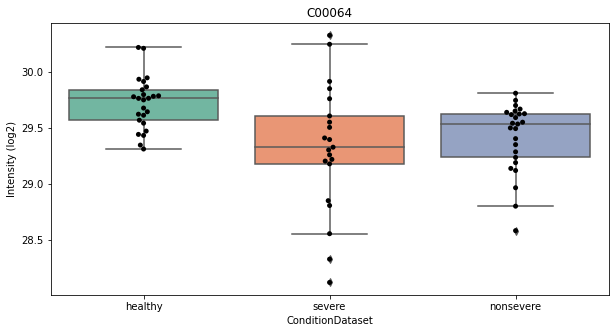

C00064 -0.39963493371366704
['C00064', 'C05100', 'C00819'] -2.1962780494017102 ['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid']  


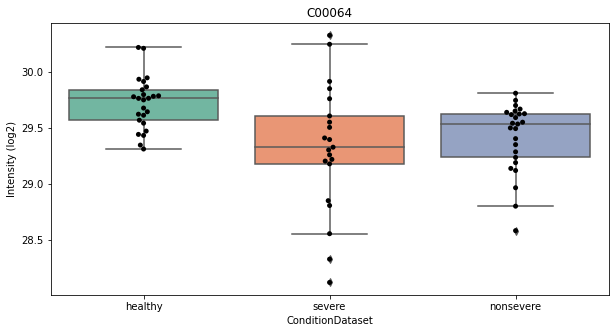

C00064 -0.39963493371366704
['C00064', 'C05100', 'C00819'] -4.68884618786971 ['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid'] o-acetyl-l-serine 


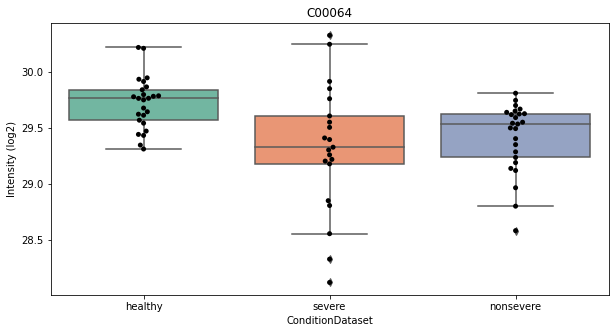

C00064 -0.39963493371366704
['C00064', 'C05100', 'C00819'] -5.339399840333269 ['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid']  


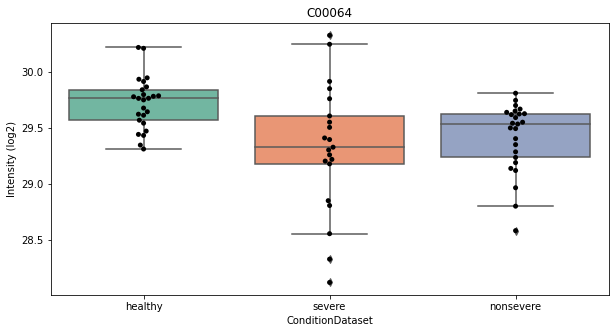

C01586 -1.7854093866392902
['C13747', 'C07480', 'C01586'] -6.5173316425727705 ['1,7-dimethylxanthine; paraxanthine$']  Hippuric acid


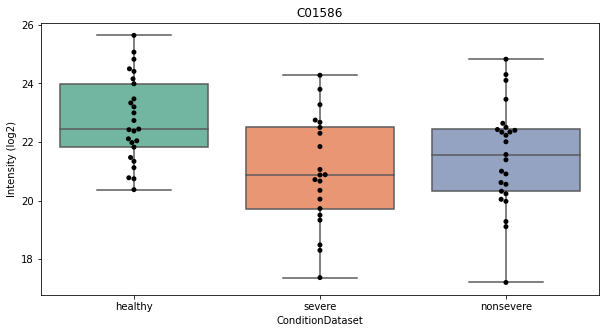

C01586 -1.7854093866392902
['C00355', 'C01586'] -1.53007627880924 ['4-(2-aminophenyl)-2,4-dioxobutanoate', 'adrenochrome$hippurate; hippuric acid; n-benzoylglycine; benzoylaminoacetic acid', '3,4-dihydroxy-l-phenylalanine']  Hippuric acid


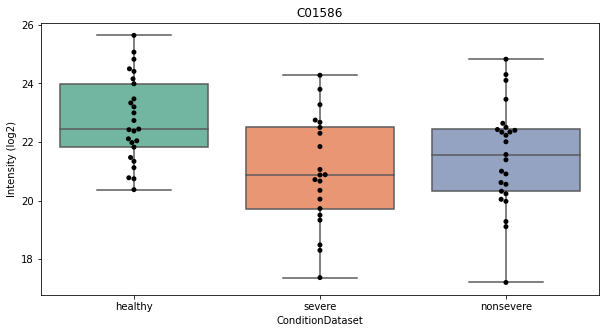

C00318 -0.426735247852434
['C00318'] 0.159511040187969   L-Carnitine


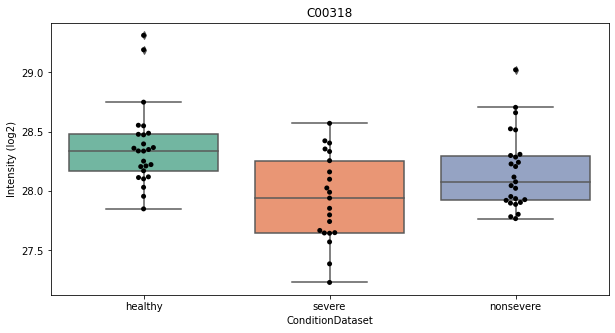

C00318 -0.426735247852434
['C00318', 'C00318'] 1.01636096892188  l-carnitine L-Carnitine


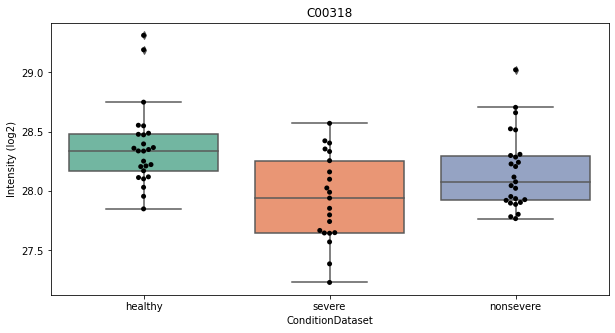

C00318 -0.426735247852434
['C00318'] -0.121814946028035   L-Carnitine


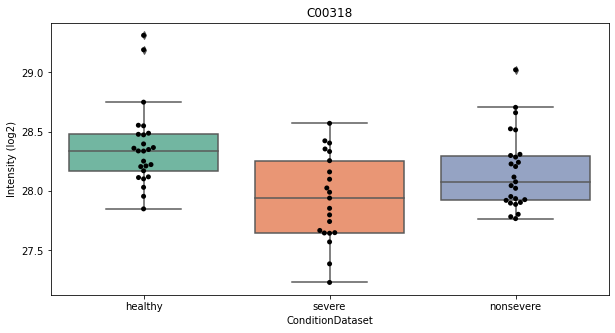

C00318 -0.426735247852434
['C00318', 'C00318', 'C00318'] -0.960372948379021 ['l-carnitine'] l-carnitine L-Carnitine


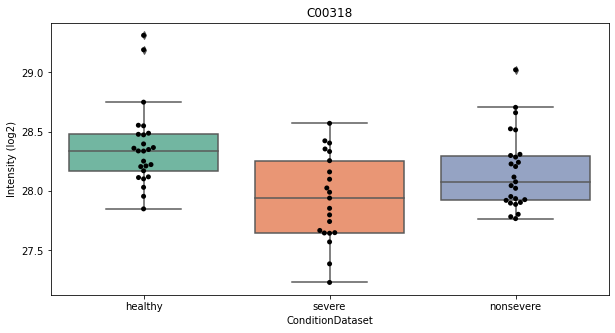

C00380 3.08624425551767
['C05522', 'C00380', 'C00380'] 12.962342802325802 ['cytosine (in dna)$cytosine'] cytosine 


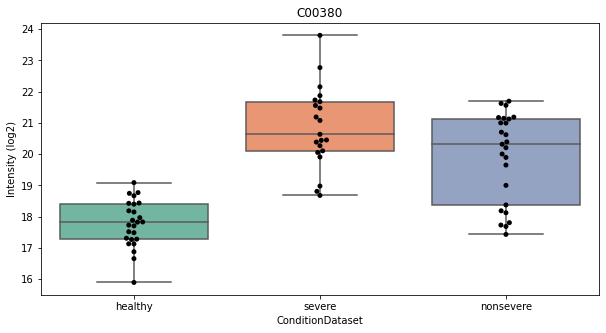

C00025 -0.447812384878716
['C00217', 'C00025', 'C05938', 'C00408'] -0.649141706140043 ['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate$5-oxo-l-proline', 'd-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde'] 5-oxoproline Pipecolic acid


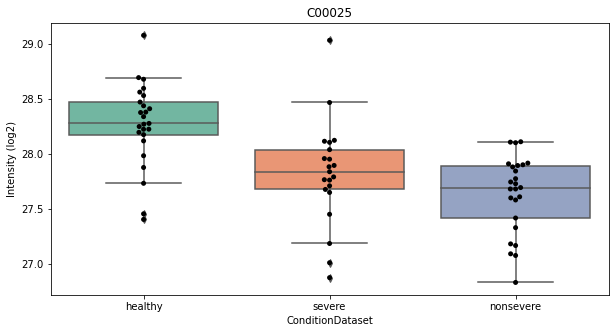

C00025 -0.447812384878716
['C00217', 'C00025', 'C05938'] -1.3978289832822999 ['d-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde']  


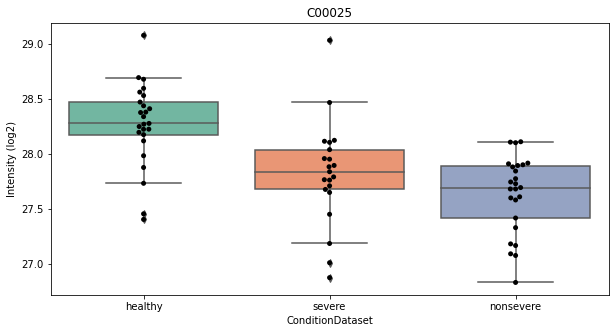

C00062 -0.40857889148539095
['C00437', 'C00062'] -0.0509318565938024 ['n2-acetyl-l-ornithine']  L-Arginine


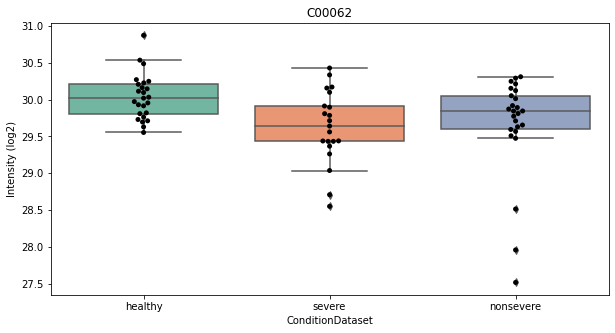

C01026 -0.464728219678424
['C00114', 'C01026'] 0.0  choline Dimethylglycine


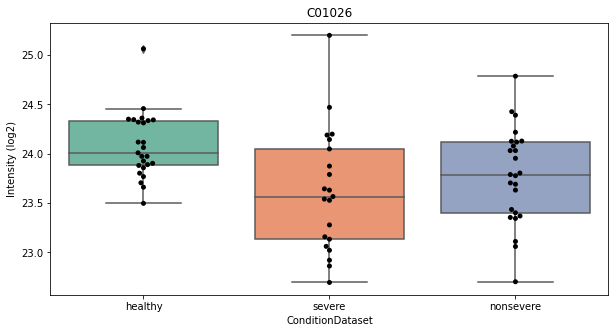

C01026 -0.464728219678424
['C01026'] -5.577425073425   Dimethylglycine


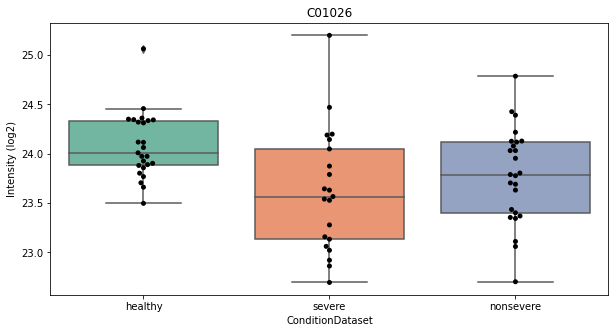

C01026 -0.464728219678424
['C02356', 'C01026', 'C00334', 'C05145', 'C01205', 'C03284'] 0.23675509453931198 ['(s)-2-aminobutanoate; (s)-2-aminobutanoic acid; (s)-2-aminobutyric acid$n,n-dimethylglycine; dimethylglycine$4-aminobutanoate$3-aminoisobutyric acid; 3-aminoisobutanoate; 3-amino-2-methylpropanoate$d-3-amino-isobutanoate$l-3-amino-isobutanoate']  


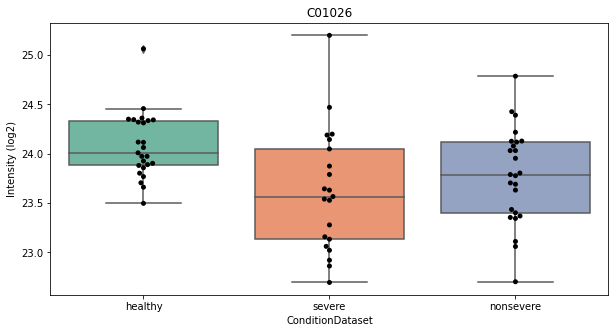

C01026 -0.464728219678424
['C02356', 'C01026', 'C00334', 'C05145', 'C01205', 'C03284', 'C01026'] 0.206239508030393 ['(s)-2-aminobutanoate; (s)-2-aminobutanoic acid; (s)-2-aminobutyric acid$n,n-dimethylglycine; dimethylglycine$4-aminobutanoate$3-aminoisobutyric acid; 3-aminoisobutanoate; 3-amino-2-methylpropanoate$d-3-amino-isobutanoate$l-3-amino-isobutanoate']  Dimethylglycine


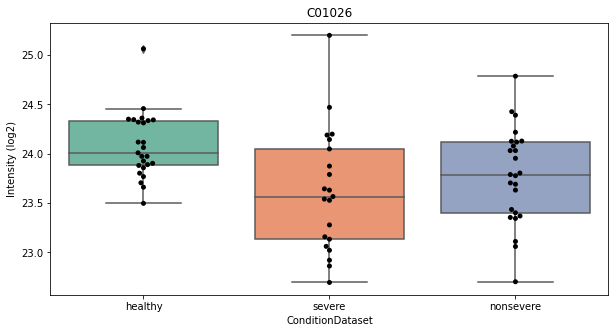

C01026 -0.464728219678424
['C00123', 'C00407', 'C01026'] 1.00945547849601 ['l-leucine$l-isoleucine']  Dimethylglycine


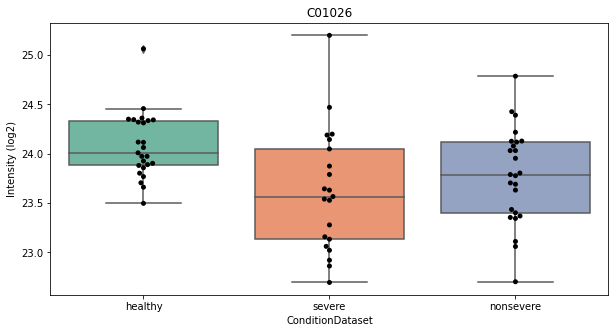

C01152 -0.494346200573094
['C01152'] -1.62226260712697 ['n(pi)-methyl-l-histidine; 1-methylhistidine; n-pros-methyl-l-histidine']  


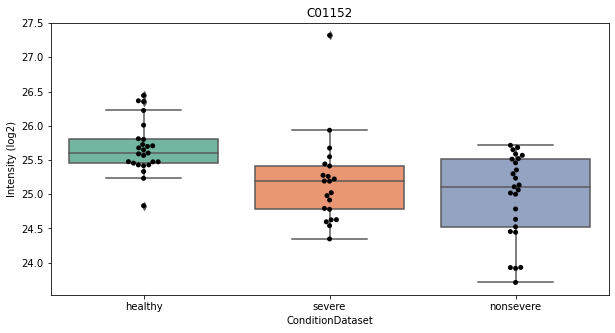

C01152 -0.494346200573094
['C01152'] -0.8881649806856841 ['n(pi)-methyl-l-histidine; 1-methylhistidine; n-pros-methyl-l-histidine']  


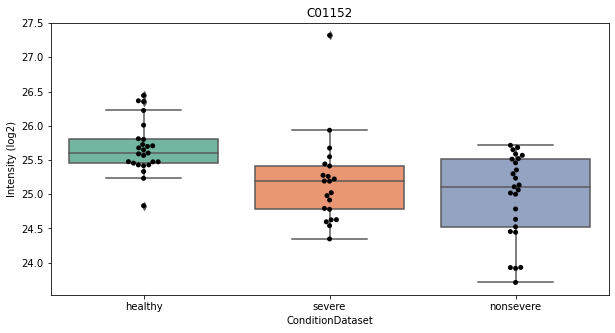

C01152 -0.494346200573094
['C01152'] 1.67430956497127 ['n(pi)-methyl-l-histidine; 1-methylhistidine; n-pros-methyl-l-histidine'] n(pi)-methyl-l-histidine 


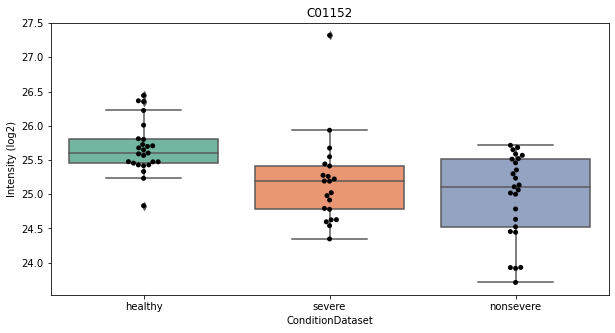

C00408 -2.64453603461353
['C00408'] 0.0   Pipecolic acid


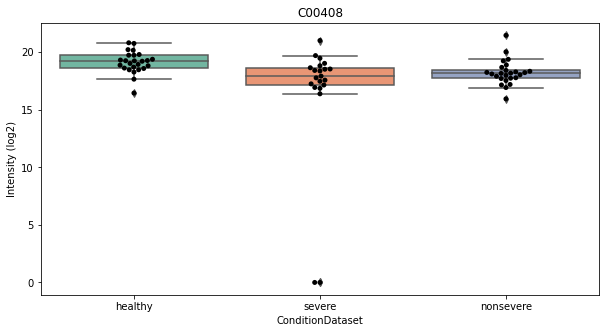

C00408 -2.64453603461353
['C00217', 'C00025', 'C05938', 'C00408'] -0.649141706140043 ['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate$5-oxo-l-proline', 'd-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde'] 5-oxoproline Pipecolic acid


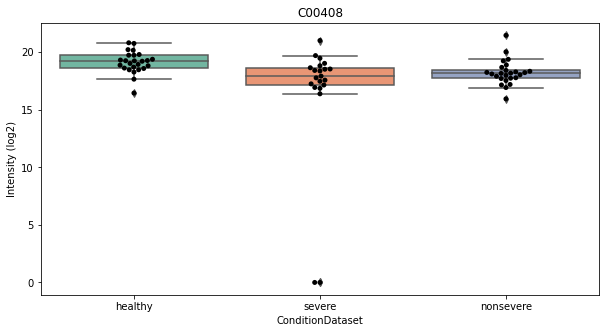

C00408 -2.64453603461353
['C05519', 'C00188', 'C00408'] -0.462357094192591 ['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate', 'l-allo-threonine$l-threonine']  Pipecolic acid


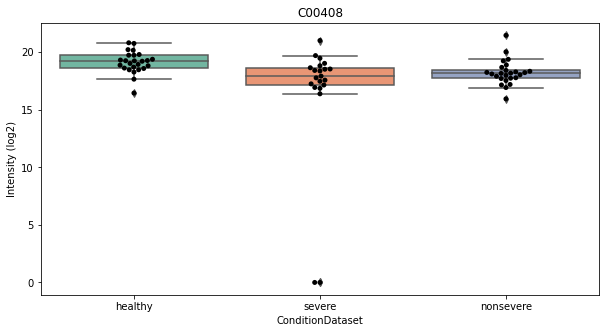

C00408 -2.64453603461353
['C05936', 'C00408', 'C00408'] 0.267874938354957 ['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid'] 5-oxoproline Pipecolic acid


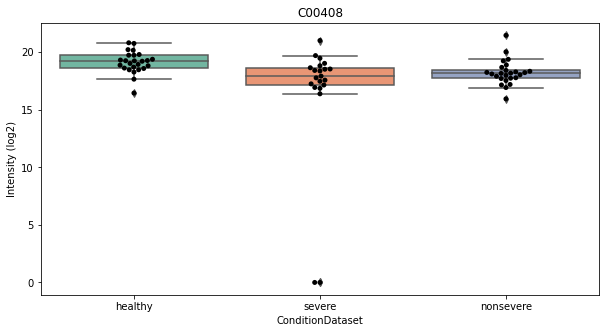

C00408 -2.64453603461353
['C05936', 'C00408'] -0.4843793899907 ['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid']  


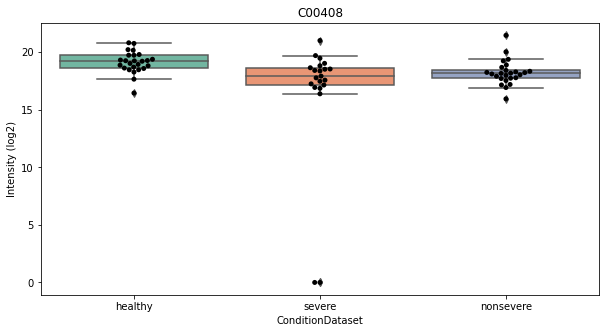

C00408 -2.64453603461353
['C05936', 'C00408'] -0.17616636627294802 ['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid']  


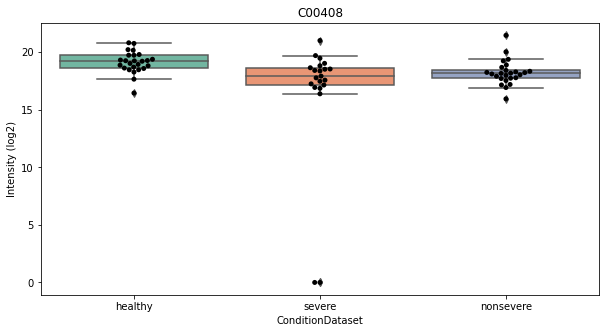

C00408 -2.64453603461353
['C00047', 'C00408'] -0.160909698672775 ['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid', 'l-lysine'] 5-oxoproline Pipecolic acid


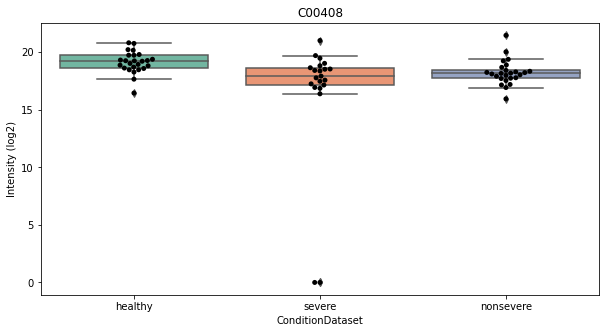

C00408 -2.64453603461353
['C05936', 'C00408'] -0.0673533368400179 ['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid']  


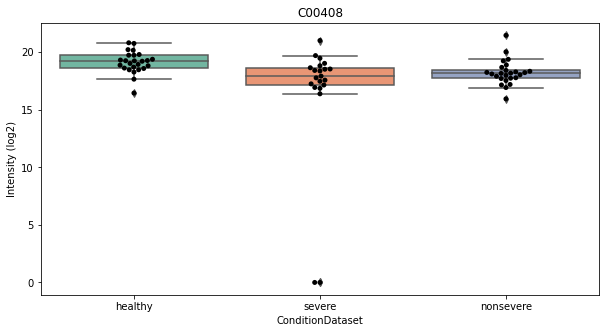

C00408 -2.64453603461353
['C05936', 'C00408', 'C00408'] 0.5508910993436371 ['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid']  Pipecolic acid


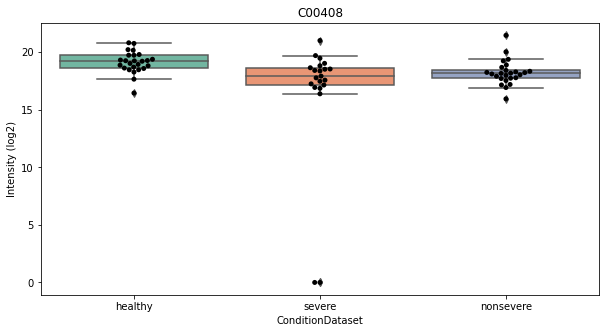

C00408 -2.64453603461353
['C05936', 'C00408'] -0.125085878785598 ['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid']  


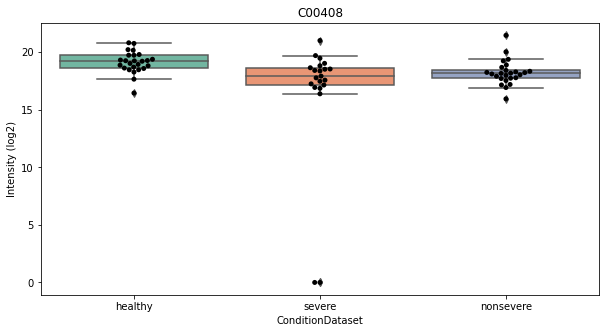

C00408 -2.64453603461353
['C05936', 'C00408'] -0.0557491077574497 ['(r)-pantothenate', 'n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid']  


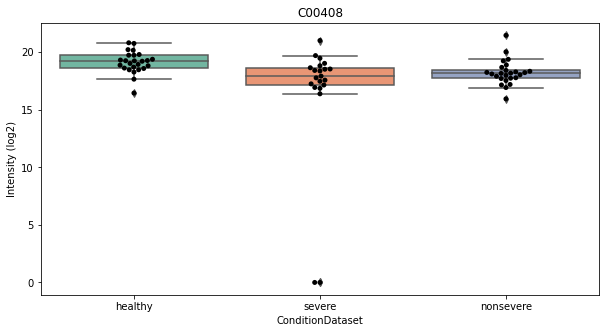

C00954 -0.5749682723179711
['C16595', 'C16587', 'C00954'] -3.11055939780338 ['indole-3-acetate$5-hydroxyindoleacetaldehyde', '4-hydroxy-5-phenyltetrahydro-1,3-oxazin-2-one$3-carbamoyl-2-phenylpropionaldehyde']  Indoleacetic acid


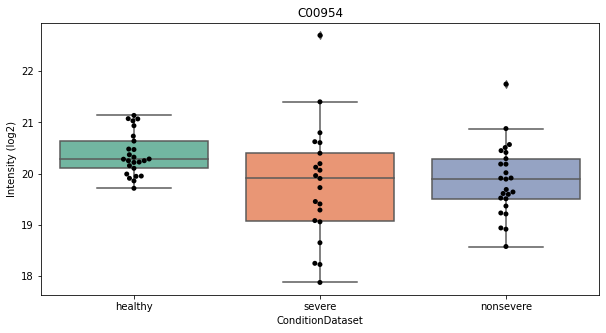

C01879 -0.24253065869089604
['C01879', 'C04281', 'C04282'] -1.09706950943779 ['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate']  


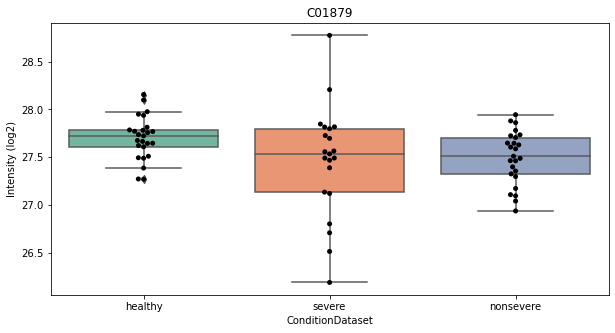

C07480 -5.59872423685673
['C13747', 'C07480', 'C01586'] -6.5173316425727705 ['1,7-dimethylxanthine; paraxanthine$']  Hippuric acid


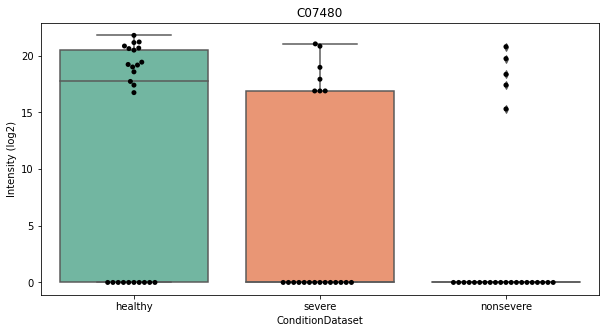

C00906 -0.37140436214429995
['C00906', 'C00064', 'C00047'] -2.63034608332642 ['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid', '5,6-dihydrothymine'] l-glutamine L-Lysine


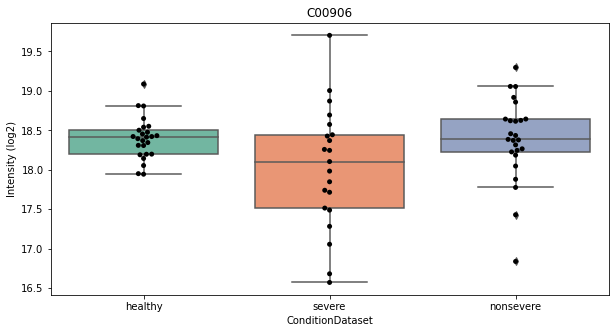

C00906 -0.37140436214429995
['C00906'] -10.0563554026259 ['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid', '5,6-dihydrothymine']  


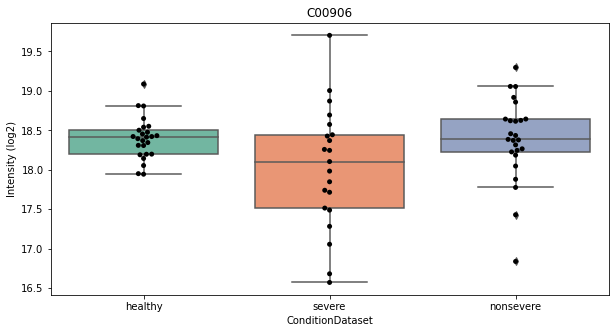

C00906 -0.37140436214429995
['C00906'] -4.643943261505339 ['5,6-dihydrothymine']  


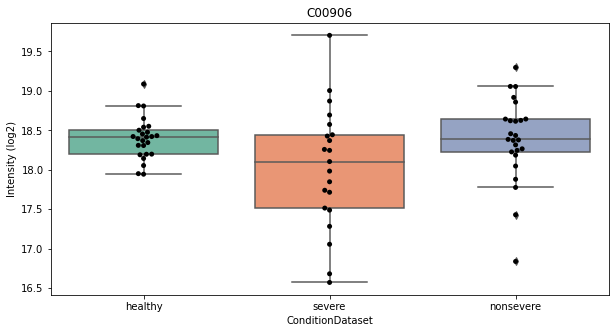

C00906 -0.37140436214429995
['C00906'] -4.00595622392325 ['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid', '5,6-dihydrothymine']  


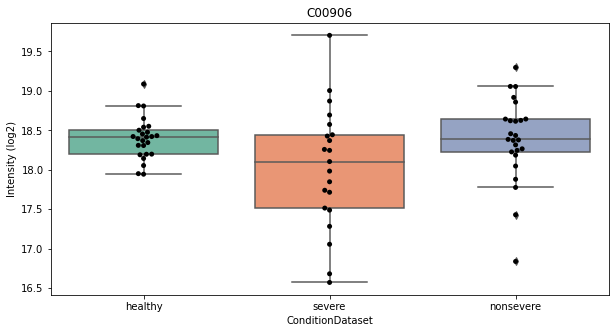

C00906 -0.37140436214429995
['C00906'] 0.127334814470849 ['5,6-dihydrothymine']  


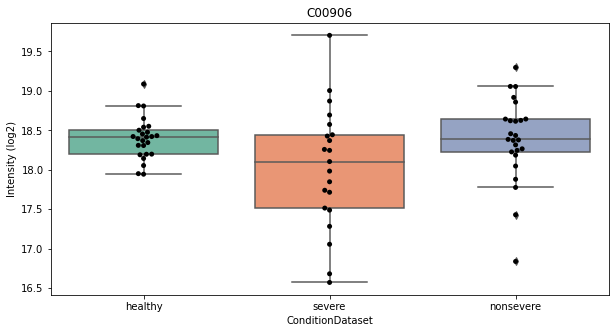

C02946 -4.46340120345192
['C03239', 'C02946', 'C04076'] 0.516617388800999 ['6-amino-2-oxohexanoate; 2-oxo-6-aminocaproate$4-acetamidobutanoate$l-2-aminoadipate 6-semialdehyde; 2-aminoadipate 6-semialdehyde']  


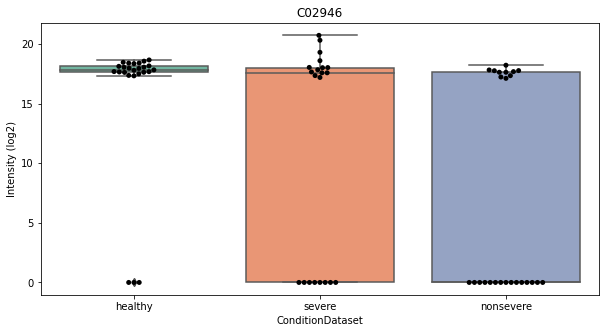

C02946 -4.46340120345192
['C03239', 'C02946', 'C04076'] 0.24966733860367202 ['6-amino-2-oxohexanoate; 2-oxo-6-aminocaproate$4-acetamidobutanoate$l-2-aminoadipate 6-semialdehyde; 2-aminoadipate 6-semialdehyde'] 4-trimethylammoniobutanoate 


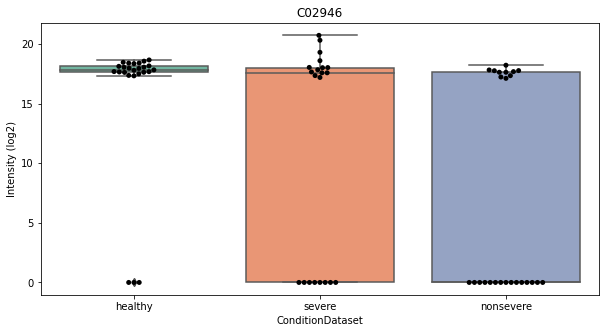

C00122 -0.298597398908729
['C00122'] -0.0703608852214153  maleic acid 


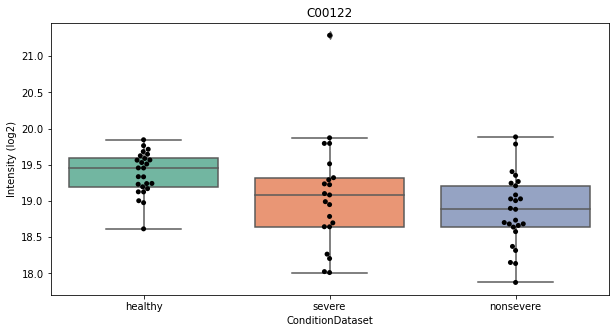

C00122 -0.298597398908729
['C00122', 'C00148'] -0.0560273730679093  maleic acid L-Proline


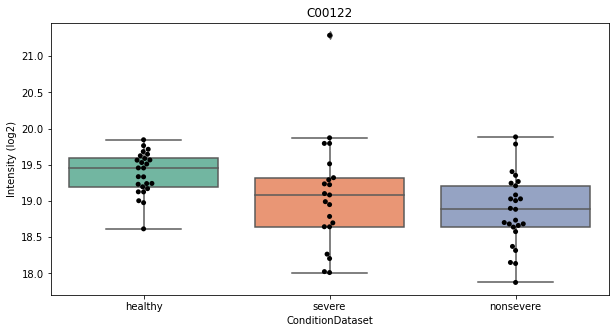

C05842 -0.61019733563651
['C05842', 'C05843'] 0.359394555950587 ["n1-methyl-2-pyridone-5-carboxamide; n'-methyl-2-pyridone-5-carboxamide; 1-methyl-5-carboxylamide-2-pyridone$n1-methyl-4-pyridone-5-carboxamide; n'-methyl-4-pyridone-5-carboxamide; 1-methyl-4-pyridone-3-carboximide"]  


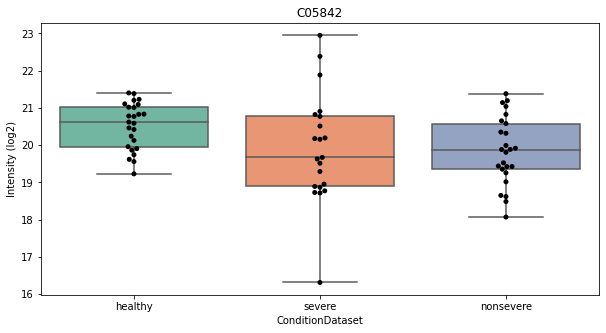

C05842 -0.61019733563651
['C05842', 'C05843'] 0.357956413762214 ["n1-methyl-2-pyridone-5-carboxamide; n'-methyl-2-pyridone-5-carboxamide; 1-methyl-5-carboxylamide-2-pyridone$n1-methyl-4-pyridone-5-carboxamide; n'-methyl-4-pyridone-5-carboxamide; 1-methyl-4-pyridone-3-carboximide"] 4-(beta-acetylaminoethyl)imidazole 


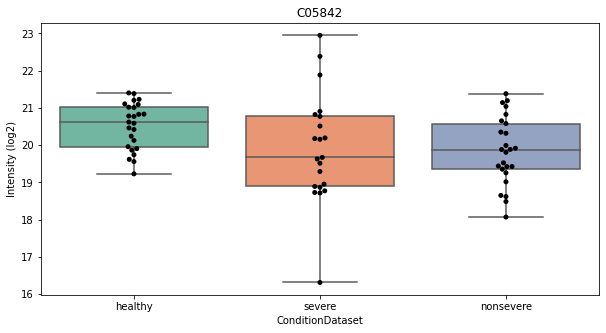

C00108 0.4101786740290301
['C00108'] -0.43642884684611605 ['anthranilate']  


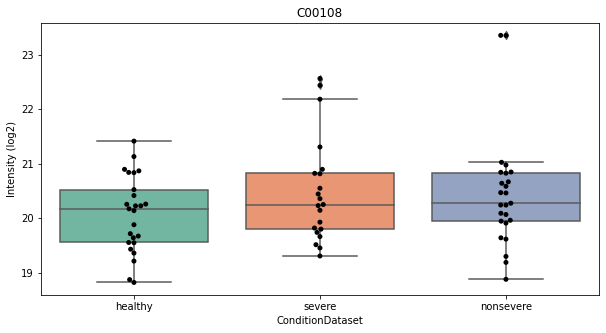

C00108 0.4101786740290301
['C00108'] -1.12338184399792 ['anthranilate']  


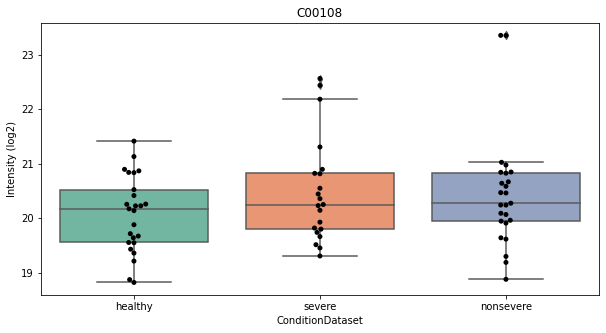

C00108 0.4101786740290301
['C00108'] 1.19118318986477 ['anthranilate']  


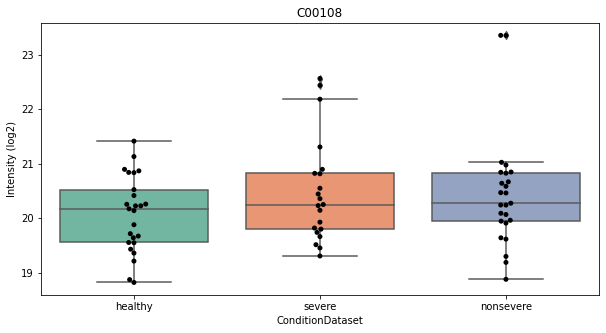

C04148 -0.6731650426479019
['C04148', 'C05642'] -5.28264613797675 ['alpha-n-phenylacetyl-l-glutamine$formyl-n-acetyl-5-methoxykynurenamine']  


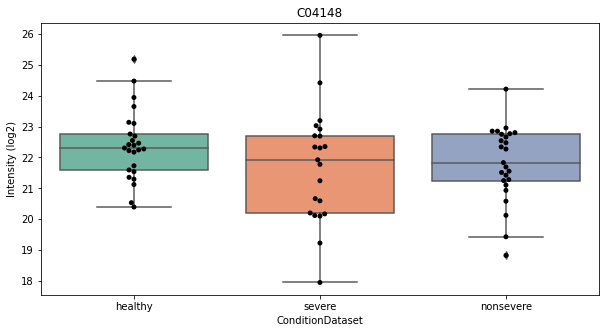

C04148 -0.6731650426479019
['C04148', 'C05642'] -0.539121773311887 ['alpha-n-phenylacetyl-l-glutamine$formyl-n-acetyl-5-methoxykynurenamine']  


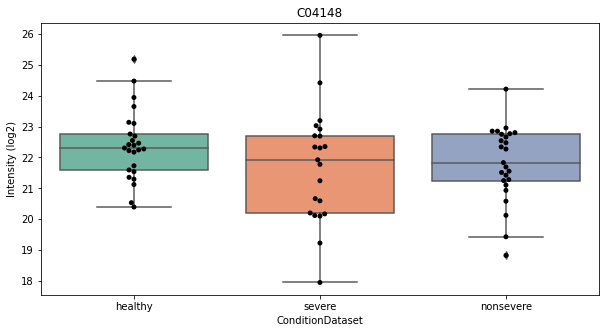

C04148 -0.6731650426479019
['C04148', 'C05642'] -2.7828634929839198 ['alpha-n-phenylacetyl-l-glutamine$formyl-n-acetyl-5-methoxykynurenamine']  


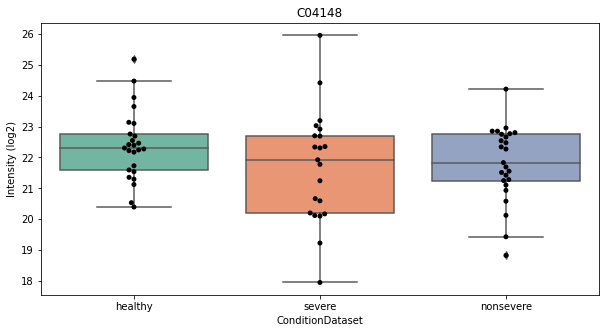

C04148 -0.6731650426479019
['C04148', 'C05642'] -1.80662305325518 ['alpha-n-phenylacetyl-l-glutamine$formyl-n-acetyl-5-methoxykynurenamine']  


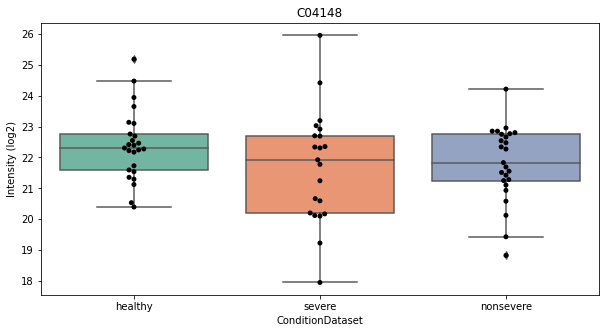

C04148 -0.6731650426479019
['C04148', 'C05642'] -0.539381428504766 ['alpha-n-phenylacetyl-l-glutamine$formyl-n-acetyl-5-methoxykynurenamine']  


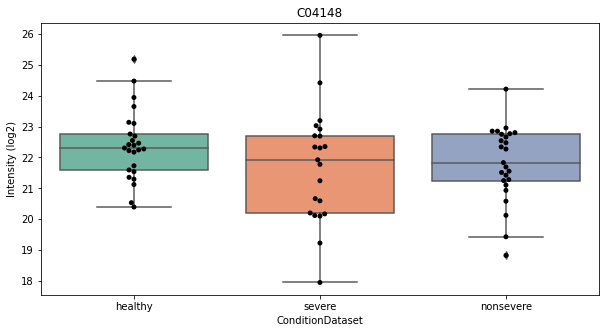

C00079 0.11455206365661802
['C00483', 'C01183', 'C02735', 'C00079'] 0.43672795603462705 ['l-phenylalanine$', 'tyramine$n,n-dimethylaniline n-oxide$phenylethanolamine; 2-amino-1-phenylethanol']  L-Phenylalanine


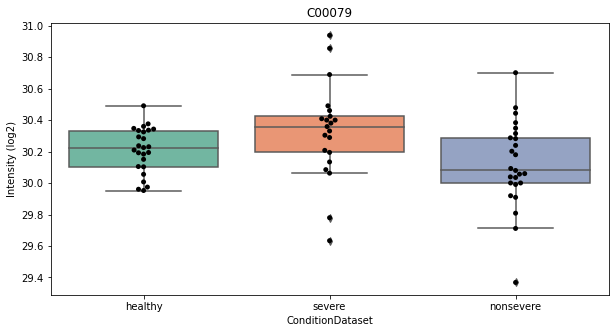

C00079 0.11455206365661802
['C00079', 'CE2172'] 0.444213460023956 ['l-phenylalanine$']  


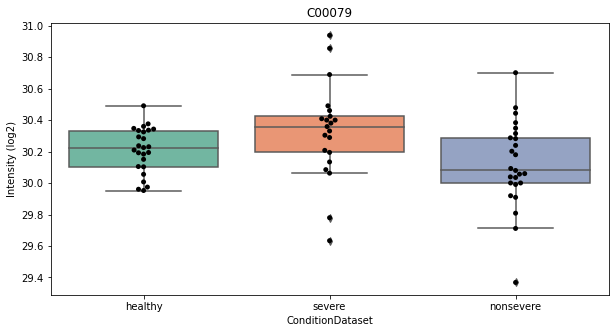

C00079 0.11455206365661802
['C00079', 'CE2172'] -6.76452846483441 ['l-phenylalanine$']  


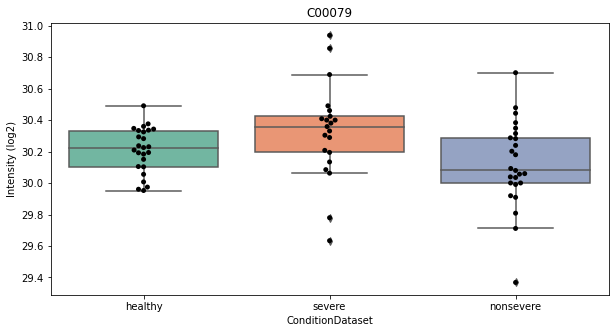

C00079 0.11455206365661802
['C05589', 'C00788', 'C00079', 'C00079'] -0.530904801135591 ['l-phenylalanine$', 'l-normetanephrine$l-adrenaline; (r)-(-)-adrenaline; (r)-(-)-epinephrine; (r)-(-)-epirenamine; (r)-(-)-adnephrine; 4-[(1r)-1-hydroxy-2-(methylamino)ethyl]-1,2-benzenediol'] l-phenylalanine L-Phenylalanine


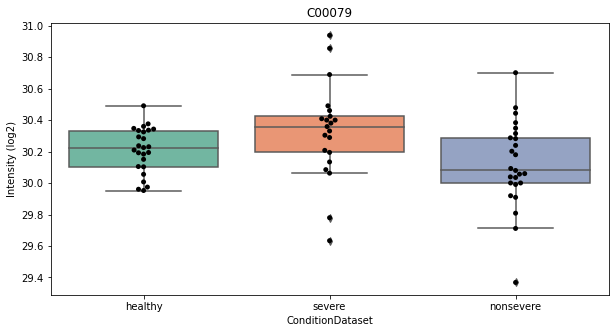

C13747 -3.85512432879323
['C13747', 'C07480', 'C01586'] -6.5173316425727705 ['1,7-dimethylxanthine; paraxanthine$']  Hippuric acid


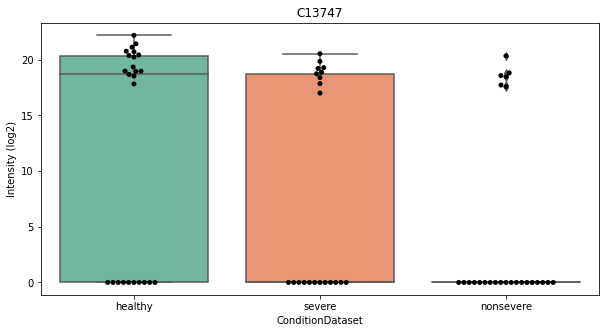

C00956 -3.2205623599920203
['C00956', 'C00719', 'C00719'] -0.0356890921986768 ['6-amino-2-oxohexanoate; 2-oxo-6-aminocaproate$4-acetamidobutanoate$l-2-aminoadipate 6-semialdehyde; 2-aminoadipate 6-semialdehyde', 'glycine betaine$5-aminopentanoate; 5-aminopentanoic acid; 5-aminovaleric acid$l-valine', 'l-2-aminoadipate; l-alpha-aminoadipate; l-alpha-aminoadipic acid; l-2-aminoadipic acid; l-2-aminohexanedioate'] betaine Betaine


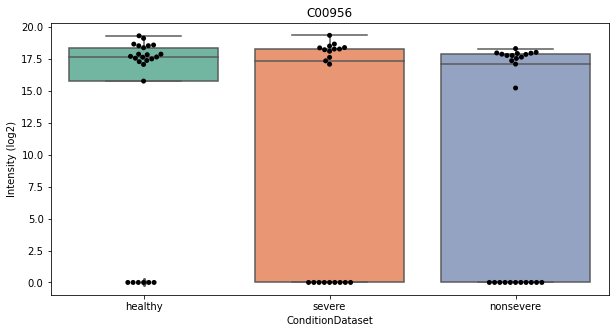

C00262 -0.277981377796472
['C00785', 'C00262'] -2.68509174839248 ['urocanate']  Hypoxanthine


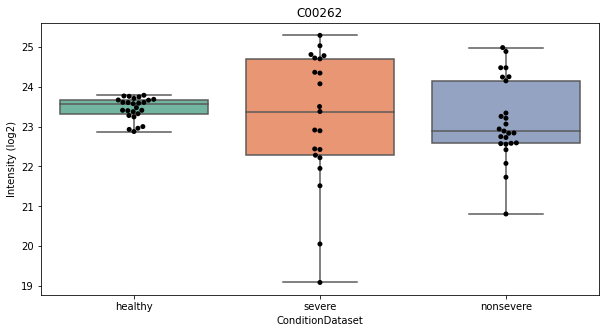

C00262 -0.277981377796472
['C00262'] -1.1835200107691202 ['hypoxanthine']  


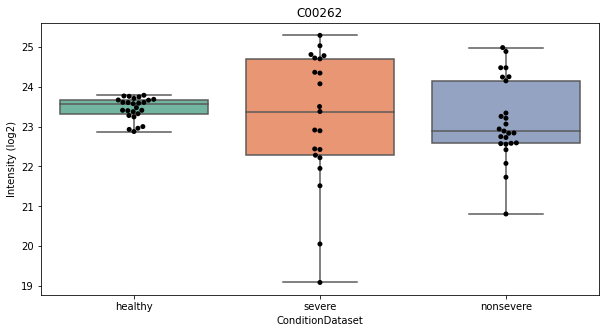

C00262 -0.277981377796472
['C00262'] -1.22639916252047 ['hypoxanthine']  


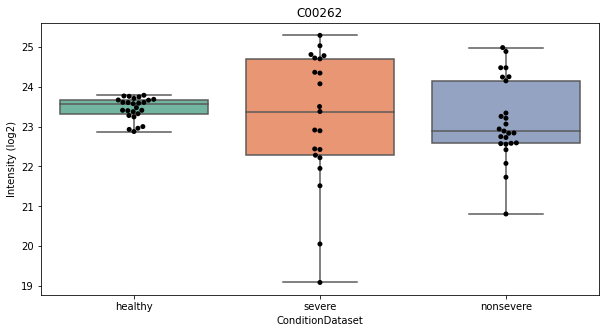

C00262 -0.277981377796472
['C00262'] -1.1423904678192 ['hypoxanthine']  


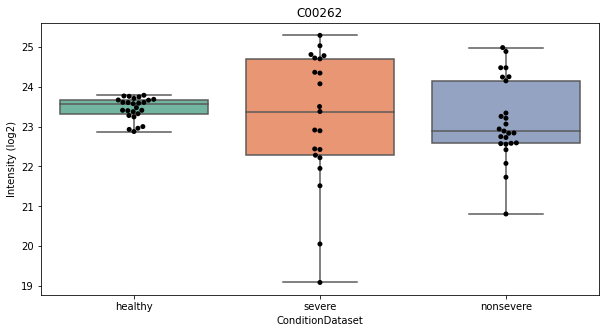

C00262 -0.277981377796472
['C00262', 'C00262', 'C00262'] 0.19371489166566 ['hypoxanthine'] hypoxanthine Hypoxanthine


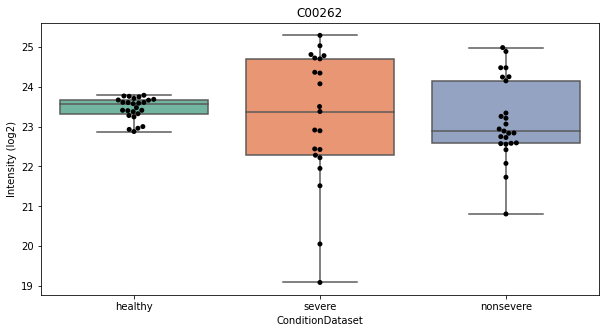

C00491 -0.43698985746938795
['C00491', 'C00491'] -7.814946930091041 ['l-cystine; l-dicysteine; l-alpha-diamino-beta-dithiolactic acid'] l-cystine 


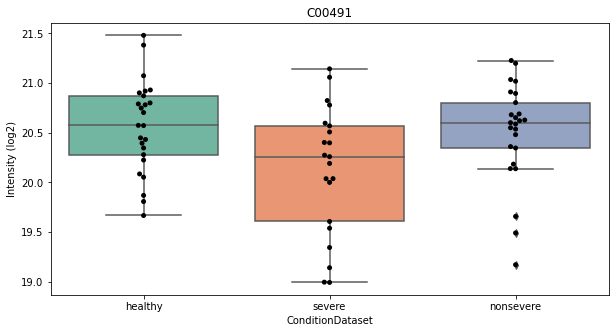

C02835 -0.40908914056122103
['C00178', 'C02835'] 0.0259566639089179 ['thymine$imidazole-4-acetate; imidazoleacetic acid; 4-imidazoleacetate'] imidazole-4-acetate 


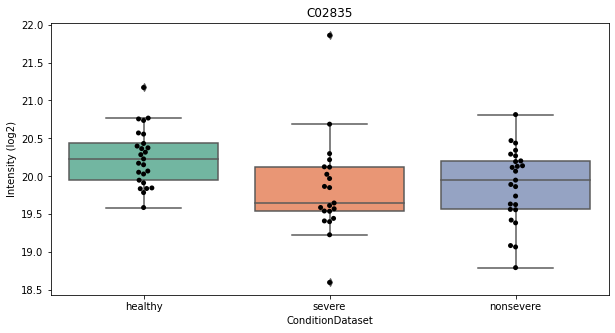

C00137 0.103033228280381
['C00031', 'C00221', 'C00247', 'C02336', 'C00267', 'C00738', 'C00936', 'C00095', 'C00962', 'C01582', 'C00795', 'C00137', 'C00293', 'C00124', 'C00984', 'C00159'] 7.995276342107531 ['d-glucose$beta-d-glucose$l-sorbose; l-xylo-hexulose$beta-d-fructose; beta-fruit sugar; beta-d-arabino-hexulose; beta-levulose; fructose$alpha-d-glucose$d-hexose$$d-fructose$beta-d-galactose$galactose$d-tagatose; lyxo-hexulose$myo-inositol$glucose$d-galactose$alpha-d-galactose$d-mannose']  


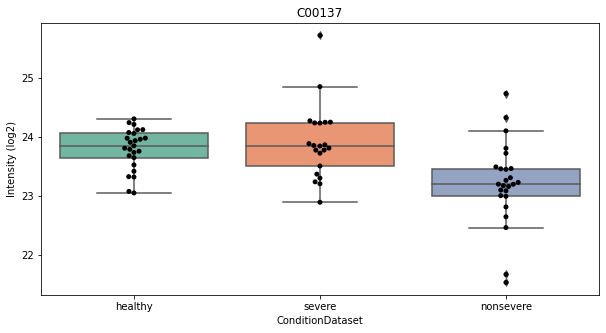

C01035 -0.12256430275614999
['C01035'] 2.52584078419477 ['5-guanidino-2-oxopentanoate; 5-guanidino-2-oxo-pentanoate; 2-oxo-5-guanidinopentanoate; 2-oxo-5-guanidino-pentanoate', '4-guanidinobutanoate'] 4-trimethylammoniobutanoate 


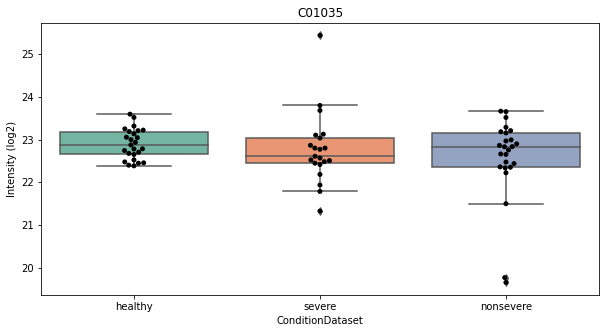

C01035 -0.12256430275614999
['C01035'] -0.306674686322637 ['l-histidine', '4-guanidinobutanoate']  


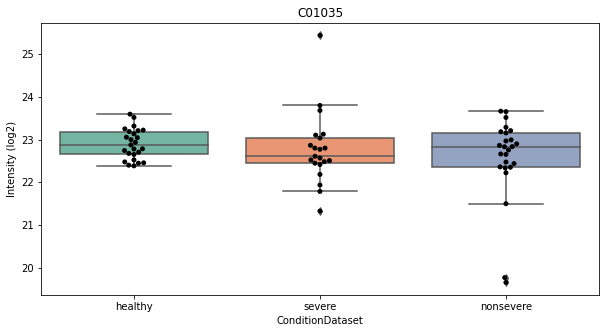

C01035 -0.12256430275614999
['C01035'] 0.149806584389648 ['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid', '5,6-dihydrothymine', '4-guanidinobutanoate']  


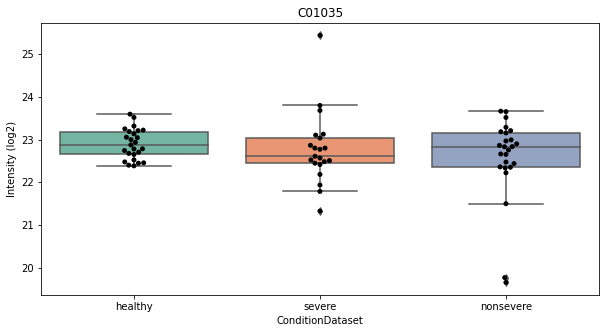

C00791 -0.0369363933668012
['C00791', 'C00147', 'C03758'] -2.20481134417115 ['nan'] adenine Dopamine


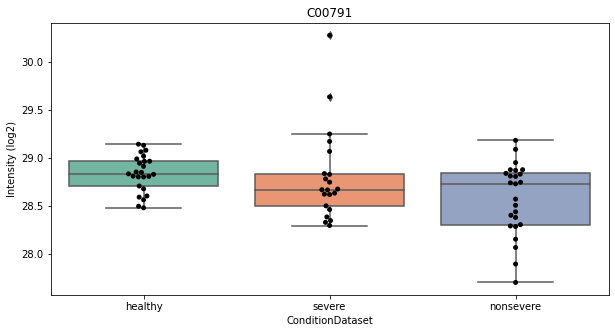

C00791 -0.0369363933668012
['C00791', 'C00791'] -1.18482914610513  creatinine Creatinine


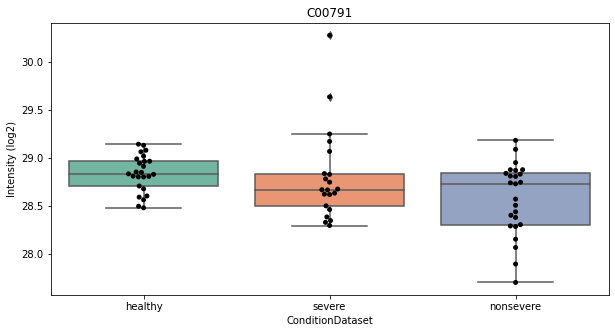

C00791 -0.0369363933668012
['C03912', 'C03564', 'C00791'] -1.6981114753715398 ['l-glutamate 5-semialdehyde; l-glutamate gamma-semialdehyde$trans-4-hydroxy-l-proline$5-aminolevulinate; 5-amino-4-oxopentanoate; 5-amino-4-oxovaleric acid$cis-4-hydroxy-d-proline$5-amino-2-oxopentanoic acid; 5-amino-2-oxopentanoate; 2-oxo-5-amino-pentanoate; 2-oxo-5-aminopentanoate; alpha-keto-delta-aminopentanoate; 2-oxo-5-aminovalerate', '1-pyrroline-5-carboxylate$1-pyrroline-2-carboxylate; 1-pyrroline-2-carboxylic acid; delta1-pyrroline 2-carboxylate'] creatinine 


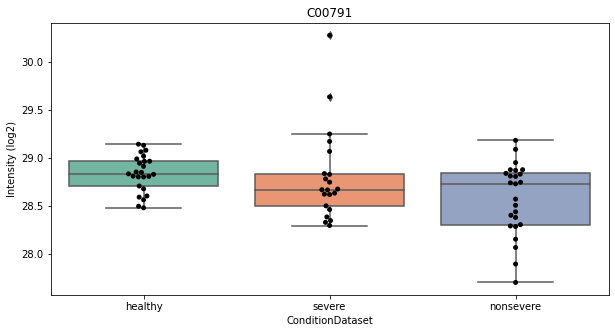

C00791 -0.0369363933668012
['C00791'] -0.801878343504342 ['creatine; alpha-methylguanidino acetic acid; methylglycocyamine', 'nan']  


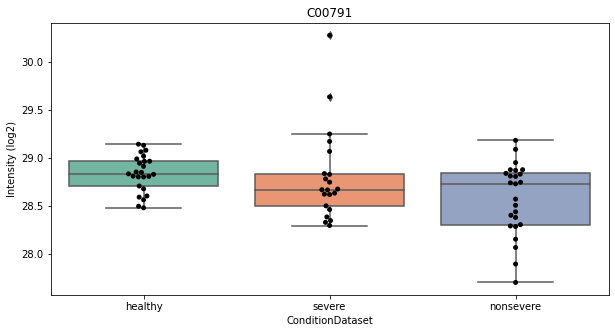

C00791 -0.0369363933668012
['C03912', 'C03564', 'C00791'] -1.14293928936543 ['porphobilinogen', 'l-glutamate 5-semialdehyde; l-glutamate gamma-semialdehyde$trans-4-hydroxy-l-proline$5-aminolevulinate; 5-amino-4-oxopentanoate; 5-amino-4-oxovaleric acid$cis-4-hydroxy-d-proline$5-amino-2-oxopentanoic acid; 5-amino-2-oxopentanoate; 2-oxo-5-amino-pentanoate; 2-oxo-5-aminopentanoate; alpha-keto-delta-aminopentanoate; 2-oxo-5-aminovalerate', '1-pyrroline-5-carboxylate$1-pyrroline-2-carboxylate; 1-pyrroline-2-carboxylic acid; delta1-pyrroline 2-carboxylate'] creatinine 


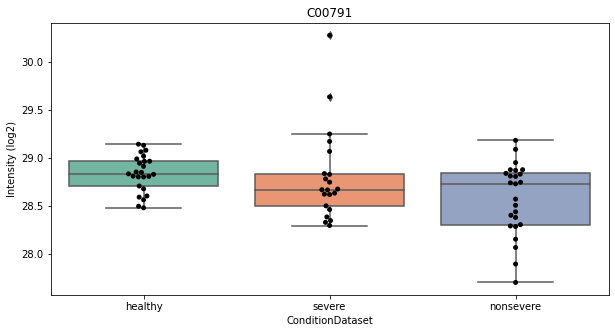

C00791 -0.0369363933668012
['C00791', 'C00791', 'C00791'] 1.31999040878948 ['creatine; alpha-methylguanidino acetic acid; methylglycocyamine', 'nan'] creatinine Creatinine


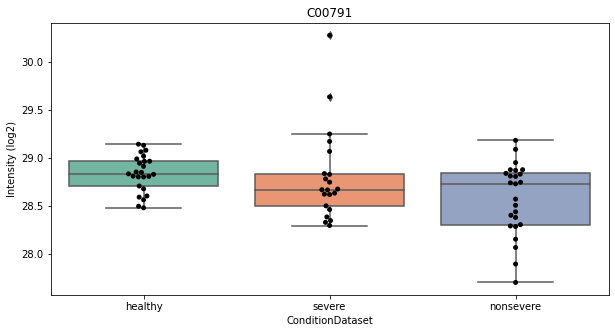

C00791 -0.0369363933668012
['C00791'] -0.7517655183635229 ['creatine; alpha-methylguanidino acetic acid; methylglycocyamine', 'nan'] 5-aminolevulinate 


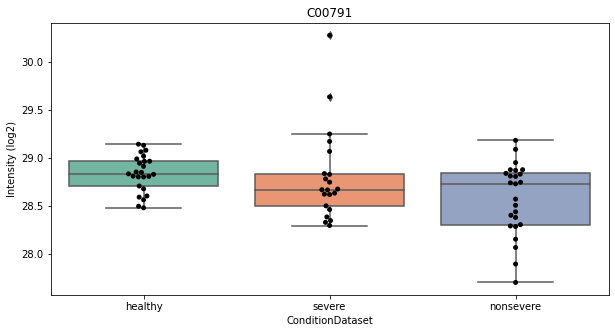

C00791 -0.0369363933668012
['C00791'] 0.0201309087432797 ['nan']  


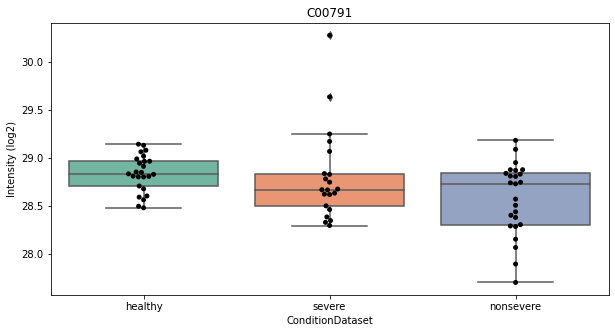

C00791 -0.0369363933668012
['C00791', 'C00791'] -0.0293358220104984  creatinine Creatinine


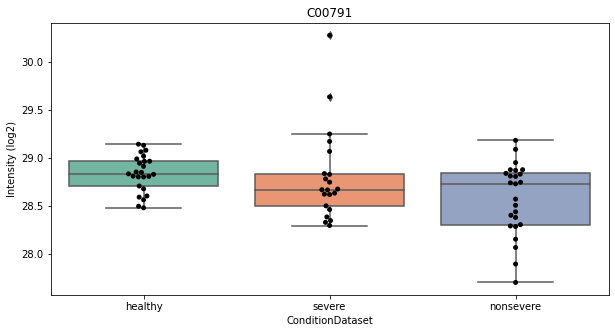

C05466 0.35190325988307297
['C05462', 'C05466'] 6.8214072040305 ['chenodeoxyglycocholate$']  


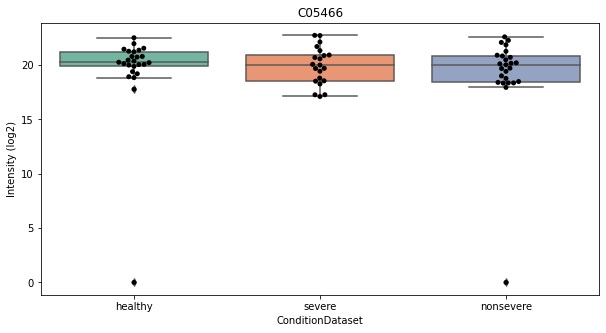

C05466 0.35190325988307297
['C05462', 'C05466'] 5.34020797420912 ['chenodeoxyglycocholate$']  


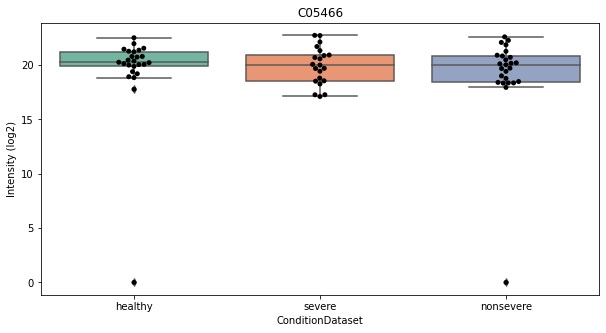

C00082 0.0309607792249835
['C00082', 'CE2174', 'C00082', 'C00082'] 0.11958364827681901 ['l-tyrosine$'] l-tyrosine L-Tyrosine


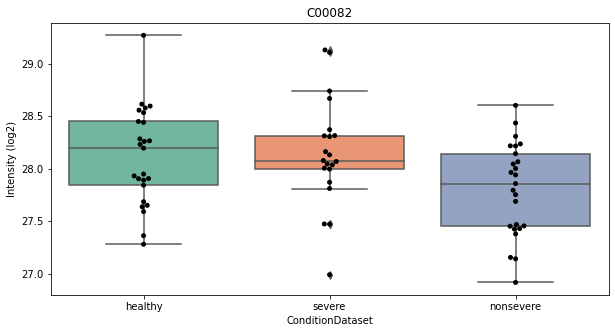

C00082 0.0309607792249835
['C00082', 'CE2174'] 0.11222038839550698 ['l-tyrosine$'] eflornithine 


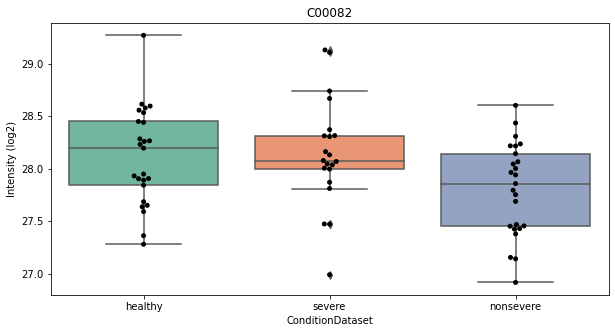

C01205 -0.041652357474149
['C02356', 'C01026', 'C00334', 'C05145', 'C01205', 'C03284'] 0.23675509453931198 ['(s)-2-aminobutanoate; (s)-2-aminobutanoic acid; (s)-2-aminobutyric acid$n,n-dimethylglycine; dimethylglycine$4-aminobutanoate$3-aminoisobutyric acid; 3-aminoisobutanoate; 3-amino-2-methylpropanoate$d-3-amino-isobutanoate$l-3-amino-isobutanoate']  


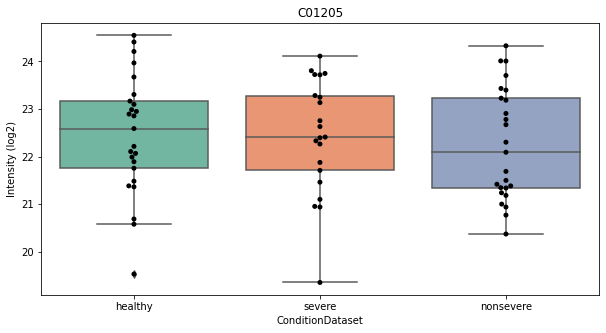

C01205 -0.041652357474149
['C02356', 'C01026', 'C00334', 'C05145', 'C01205', 'C03284', 'C01026'] 0.206239508030393 ['(s)-2-aminobutanoate; (s)-2-aminobutanoic acid; (s)-2-aminobutyric acid$n,n-dimethylglycine; dimethylglycine$4-aminobutanoate$3-aminoisobutyric acid; 3-aminoisobutanoate; 3-amino-2-methylpropanoate$d-3-amino-isobutanoate$l-3-amino-isobutanoate']  Dimethylglycine


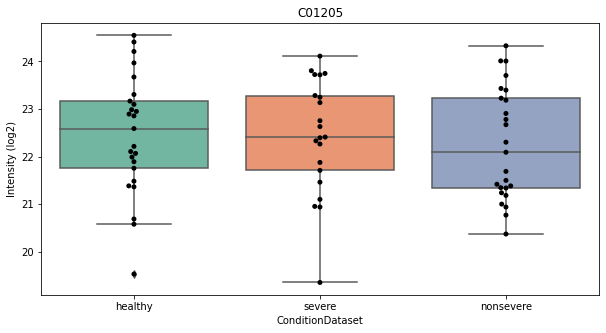

In [196]:
covids = []
covidlogfc = []
metalogfc = []
metaids = []
annotations = []
keggano = []
nonscovidlogfc = []

for row_id, row in limma_severe.iterrows():
    covid_logfc = row['logFC']
    covid_pval = row['P.Value']
    nonscovid_logfc = limma_nonsevere.loc[row_id]['logFC']
    for peak in peakinfolist:
        peak_keggs = peak.get_possible_kegg_ids()
        if row_id in peak_keggs:
            
                print(row_id, covid_logfc)
                print(peak.get_possible_kegg_ids(), peak.logfc, peak.mm_annotation, peak.std_annotation, peak.ms2_annotation )
                covids.append(row_id)
                keggano.append(get_metab_name_by_kegg(metabolites, row_id))
                metaids.append(peak_keggs)
                covidlogfc.append(covid_logfc)
                nonscovidlogfc.append(nonscovid_logfc)
                metalogfc.append(peak.logfc)
                annotations.append((peak.mm_annotation, peak.std_annotation, peak.ms2_annotation))
                plot_boxplots(data_log_unique, str(row_id), order = ['healthy', 'severe', 'nonsevere'])
                if peak.cid in samples_values_filled.index:
                    peak.plot_boxplots(samples_values_filled)
                

In [173]:
logfc = pd.DataFrame([covids, keggano, covidlogfc, nonscovidlogfc, metalogfc, metaids, annotations], ("KEGG id", "Name", "Severe_Covid_LogFC","Nonsevere_Covid_LogFC", "Meta_LogFC", "Meta-KEGG id", "Anno")).transpose()

In [174]:
logfc.to_csv(osp+'covid19_data/comparison_covid_metadata_logfc.csv')

In [175]:
for row_id, row in limma_table.iterrows():
    covid_logfc = row['logFC']
    covid_pval = row['P.Value']
    for peak in peakinfolist:
        if row_id in peak.get_possible_kegg_ids():
            if covid_logfc < 0 and peak.logfc < 0:
                print(row_id, covid_logfc)
                print(peak.get_possible_kegg_ids(), peak.logfc, peak.mm_annotation, peak.std_annotation, peak.ms2_annotation )
                plot_boxplots(data_log_unique, row_id, order = ['healthy', 'severe', 'nonsevere'])
                peak.plot_boxplots(samples_values_filled)
                

C00148 -0.8746151925771809
['CE1944', 'C00148'] -0.06299012971078 ['4-aminobutanal; 4-aminobutyraldehyde; butyraldehyde, 4-amino-', '1-pyrroline']  L-Proline


KeyError: 'C00148'

<Figure size 720x360 with 0 Axes>

In [192]:
def plot_boxplots(data, cid, order):
        import seaborn as sns
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10,5))

        ax = sns.boxplot(y=data[str(cid)], x='ConditionDataset', data = data, order = order, palette = 'Set2' )
        ax = sns.swarmplot(y=data[str(cid)], x='ConditionDataset', data = data, order = order, color="black")

        plt.ylabel("Intensity (log2)")
        plt.title(cid)
        plt.show()

In [188]:
data_log_unique = data_log_unique.transpose()

In [189]:
data_log_unique['ConditionDataset'] = sample_description['group']

In [91]:
samples_values_filled = pd.read_csv(osp+'/pymz/filtered_samples_log_filled_description.csv', index_col = 0)

In [190]:
data_log_unique

,C21482,C18218,C05127,C01152,C02918,C16358,C00956,C02261,C01344,C00365,...,C00082,C00106,C00366,C00086,C00015,C07880,C00141,C00655,C02470,ConditionDataset
h_jkdz1,24.210524,21.370881,16.420754,25.810118,0.000000,19.162571,17.389180,26.517422,0.000000,17.690765,...,27.637916,0.000000,25.855854,28.936938,24.601275,20.752001,29.551342,16.224587,0.000000,healthy
h_jkdz2,22.605535,20.971685,0.000000,25.800437,17.470054,16.530773,17.883291,26.157644,0.000000,18.305245,...,27.949310,16.230808,25.559293,28.382798,24.300106,17.530614,29.324517,14.796285,0.000000,healthy
h_jkdz3,23.216722,20.463232,16.495419,25.726539,17.773398,17.196579,17.710260,26.293190,0.000000,18.194139,...,27.651819,16.225115,25.451582,28.554048,24.288461,17.332919,29.581627,0.000000,0.000000,healthy
h_jkdz4,22.344858,20.959265,0.000000,25.428610,17.296169,20.270406,17.296101,26.303473,0.000000,17.500641,...,27.843158,16.230857,26.289268,27.961956,24.404755,20.261283,29.227362,0.000000,0.000000,healthy
h_jkdz5,24.252105,21.274690,17.285808,25.707397,18.290507,0.000000,18.541066,26.610419,0.000000,17.880056,...,28.231796,0.000000,25.257649,28.730321,24.313438,19.395695,29.679986,0.000000,0.000000,healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_ZX17,21.612682,21.482624,0.000000,24.540413,19.322959,0.000000,0.000000,26.284874,16.855921,16.533532,...,27.811830,17.120874,25.477085,27.588773,23.855657,21.202083,28.958423,15.725074,0.000000,severe
s_ZX18,20.483626,20.155726,0.000000,24.628327,19.673094,17.062846,0.000000,25.893156,15.223069,0.000000,...,26.991149,16.924908,24.449419,27.870017,22.381212,20.219033,27.804448,0.000000,0.000000,severe
s_ZX19,21.406291,21.490707,17.077231,25.934691,21.943916,0.000000,18.518485,26.125675,17.638733,0.000000,...,28.372340,19.127080,25.184266,28.630050,23.522847,18.814398,28.830787,16.488677,20.981943,severe
s_ZX20,21.014045,20.434726,0.000000,25.260903,18.115210,16.630043,0.000000,26.122675,17.328564,16.811362,...,29.131338,0.000000,23.850076,27.904608,23.322871,21.806713,28.982194,15.670805,18.276788,severe


In [1]:
from tqdm import tqdm 

In [2]:
for i in tqdm(range(int(9e6))): 
    pass

100%|██████████| 9000000/9000000 [00:03<00:00, 2796928.00it/s]
